# Repairing Code Automatically

So far, we have discussed how to track failures and how to locate defects in code. Let us now discuss how to _repair_ defects – that is, to correct the code such that the failure no longer occurs. We will discuss how to _repair code automatically_ – by systematically searching through possible fixes and evolving the most promising candidates.

In [1]:
from bookutils import YouTubeVideo

import asyncio
import time
import types
import functools
import astunparse

from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from multiprocessing import Pool,Queue,Process,Value, Pipe

YouTubeVideo("UJTf7cW0idI")

**Prerequisites**

* Re-read the [introduction to debugging](Intro_Debugging.ipynb), notably on how to properly fix code.
* We make use of automatic fault localization, as discussed in the [chapter on statistical debugging](StatisticalDebugger.ipynb).
* We make extensive use of code transformations, as discussed in [the chapter on tracing executions](Tracer.ipynb).
* We make use of [delta debugging](DeltaDebugger.ipynb).

In [2]:
import bookutils

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from debuggingbook.Repairer import <identifier>
```

and then make use of the following features.


This chapter provides tools and techniques for automated repair of program code. The `Repairer()` class takes a `DifferenceDebugger` debugger as input (such as `OchiaiDebugger` from [the chapter on statistical debugging](StatisticalDebugger.ipynb). A typical setup looks like this:

```python
from debuggingbook.StatisticalDebugger import OchiaiDebugger

debugger = OchiaiDebugger()
for inputs in TESTCASES:
    with debugger:
        test_foo(inputs)
...

repairer = Repairer(debugger)
```
Here, `test_foo()` is a function that raises an exception if the tested function `foo()` fails. If `foo()` passes, `test_foo()` should not raise an exception.

The `repair()` method of a `Repairer` searches for a repair of the code covered in the debugger (except for methods starting or ending in `test`, such that `foo()`, not `test_foo()` is repaired). `repair()` returns the best fix candidate as a pair `(tree, fitness)` where `tree` is a [Python abstract syntax tree](http://docs.python.org/3/library/ast) (AST) of the fix candidate, and `fitness` is the fitness of the candidate (a value between 0 and 1). A `fitness` of 1.0 means that the candidate passed all tests. A typical usage looks like this:

```python
import astor

tree, fitness = repairer.repair()
print(astor.to_source(tree), fitness)
```

Here is a complete example for the `middle()` program. This is the original source code of `middle()`:

```python
def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return y
    else:
        if x > y:
            return y
        elif x > z:
            return x
    return z```
We set up a function `middle_test()` that tests it. The `middle_debugger`  collects testcases and outcomes:

```python
>>> middle_debugger = OchiaiDebugger()

>>> for x, y, z in MIDDLE_PASSING_TESTCASES + MIDDLE_FAILING_TESTCASES:
>>>     with middle_debugger:
>>>         m = middle_test(x, y, z)
```
The repairer attempts to repair the invoked function (`middle()`). The returned AST `tree` can be output via `astor.to_source()`:

```python
>>> middle_repairer = Repairer(middle_debugger)
>>> tree, fitness = middle_repairer.repair()
>>> print(astor.to_source(tree), fitness)

def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return x
    elif x > y:
        return y
    elif x > z:
        return x
    return z
 1.0
```
Here are the classes defined in this chapter. A `Repairer` repairs a program, using a `StatementMutator` and a `CrossoverOperator` to evolve a population of candidates.


![](PICS/Repairer-synopsis-1.svg)



## Automatic Code Repairs

So far, we have discussed how to locate defects in code, how to track failures back to the defects that caused them, and how to systematically determine failure conditions. Let us now address the last step in debugging – namely, how to _automatically fix code_.

Already in the [introduction to debugging](Intro_Debugging.ipynb), we have discussed how to fix code manually. Notably, we have established that a _diagnosis_ (which induces a fix) should show _causality_ (i.e, how the defect causes the failure) and _incorrectness_ (how the defect is wrong). Is it possible to obtain such a diagnosis automatically?

In this chapter, we introduce a technique of _automatic code repair_ – that is, for a given failure, automatically determine a fix that makes the failure go away. To do so, we randomly (but systematically) _mutate_ the program code – that is, insert, change, and delete fragments – until we find a change that actually causes the failing test to pass.

If this sounds like an audacious idea, that is because it is. But not only is _automated program repair_ one of the hottest topics of software research in the last decade, it is also being increasingly deployed in industry. At Facebook, for instance, every failing test report comes with an automatically generated _repair suggestion_ – a suggestion that already has been validated to work. Programmers can apply the suggestion as is or use it as basis for their own fixes.

### The middle() Function

Let us introduce our ongoing example. In the [chapter on statistical debugging](StatisticalDebugger.ipynb), we have introduced the `middle()` function – a function that returns the "middle" of three numbers `x`, `y`, and `z`:

In [3]:
from StatisticalDebugger import middle

In [4]:
# ignore
from bookutils import print_content

In [5]:
# ignore
import inspect

In [6]:
# ignore
_, first_lineno = inspect.getsourcelines(middle)
middle_source = inspect.getsource(middle)
print_content(middle_source, '.py', start_line_number=first_lineno)

589  def middle(x, y, z):
590      if y < z:
591          if x < y:
592              return y
593          elif x < z:
594              return y
595      else:
596          if x > y:
597              return y
598          elif x > z:
599              return x
600      return z

In most cases, `middle()` just runs fine:

In [7]:
middle(4, 5, 6)

5

In some other cases, though, it does not work correctly:

In [8]:
middle(2, 1, 3)

1

### Validated Repairs

Now, if we only want a repair that fixes this one given failure, this would be very easy. All we have to do is to replace the entire body by a single statement:

In [9]:
def middle_sort_of_fixed(x, y, z):
    return x

You will concur that the failure no longer occurs:

In [10]:
middle_sort_of_fixed(2, 1, 3)

2

But this, of course, is not the aim of automatic fixes, nor of fixes in general: We want our fixes not only to make the given failure go away, but we also want the resulting code to be _correct_ (which, of course, is a lot harder).

Automatic repair techniques therefore assume the existence of a _test suite_ that can check whether an implementation satisfies its requirements. Better yet, one can use the test suite to gradually check _how close_ one is to perfection: A piece of code that satisfies 99% of all tests is better than one that satisfies ~33% of all tests, as `middle_sort_of_fixed()` would do.

### Genetic Optimization

The master plan for automatic repair follows the principle of _genetic optimization_. Roughly spoken, genetic optimization is a _metaheuristic_ inspired by the process of _natural selection_. The idea is to _evolve_ a selection of _candidate solutions_ towards a maximum _fitness_:

1. Have a selection of _candidates_.
2. Determine the _fitness_ of each candidate.
3. Retain those candidates with the _highest fitness_.
4. Create new candidates from the retained candidates, by applying genetic operations:
    * _Mutation_ mutates some aspect of a candidate.
    * _CrossoverOperator_ creates new candidates combining features of two candidates.
5. Repeat until an optimal solution is found.

Applied for automated program repair, this means the following steps:

1. Have a _test suite_ with both failing and passing tests that helps asserting correctness of possible solutions.
2. With the test suite, use [fault localization](StatisticalDebugger.ipynb) to determine potential code locations to be fixed.
3. Systematically _mutate_ the code (by adding, changing, or deleting code) and _cross_ code to create possible fix candidates.
4. Identify the _fittest_ fix candidates – that is, those that satisfy the most tests.
5. _Evolve_ the fittest candidates until a perfect fix is found, or until time resources are depleted.

Let us illustrate these steps in the following sections.

## A Test Suite

In automated repair, the larger and the more thorough the test suite, the higher the quality of the resulting fix (if any). Hence, if we want to repair `middle()` automatically, we need a good test suite – with good inputs, but also with good checks.

The function `middle_testcase()` returns a random input for `middle()`:

In [11]:
import random

In [12]:
def middle_testcase():
    x = random.randrange(10)
    y = random.randrange(10)
    z = random.randrange(10)
    return x, y, z

In [13]:
[middle_testcase() for i in range(5)]

[(9, 0, 5), (0, 1, 9), (9, 0, 9), (2, 9, 0), (4, 7, 2)]

The function `middle_test()` simply checks if `middle()` operates correctly – by placing `x`, `y`, and `z` in a list, sorting it, and taking the middle argument. If `middle()` fails, `middle_test()` raises an exception.

In [14]:
def middle_test(x, y, z):
    m = middle(x, y, z)
    assert m == sorted([x, y, z])[1]

In [15]:
middle_test(4, 5, 6)

In [16]:
from ExpectError import ExpectError

In [17]:
with ExpectError():
    middle_test(2, 1, 3)

Traceback (most recent call last):
  File "<ipython-input-17-ae2957225406>", line 2, in <module>
    middle_test(2, 1, 3)
  File "<ipython-input-14-6bd1639308bf>", line 3, in middle_test
    assert m == sorted([x, y, z])[1]
AssertionError (expected)


The function `middle_passing_testcase()` searches and returns a triple `x`, `y`, `z` that causes `middle_test()` to pass.

In [18]:
def middle_passing_testcase():
    while True:
        try:
            x, y, z = middle_testcase()
            _ = middle_test(x, y, z)
            return x, y, z
        except AssertionError:
            pass

In [19]:
(x, y, z) = middle_passing_testcase()
m = middle(x, y, z)
print(f"middle({x}, {y}, {z}) = {m}")

middle(1, 6, 1) = 1


The function `middle_failing_testcase()` does the same; but its triple `x`, `y`, `z` causes `middle_test()` to fail.

In [20]:
def middle_failing_testcase():
    while True:
        try:
            x, y, z = middle_testcase()
            _ = middle_test(x, y, z)
        except AssertionError:
            return x, y, z

In [21]:
(x, y, z) = middle_failing_testcase()
m = middle(x, y, z)
print(f"middle({x}, {y}, {z}) = {m}")

middle(5, 2, 6) = 2


With these, we can define two sets of test cases, each with 100 inputs.

In [22]:
MIDDLE_TESTS = 100

In [23]:
MIDDLE_PASSING_TESTCASES = [middle_passing_testcase()
                            for i in range(MIDDLE_TESTS)]

In [24]:
MIDDLE_FAILING_TESTCASES = [middle_failing_testcase()
                            for i in range(MIDDLE_TESTS)]

## Locating the Defect

Our next step is to find potential defect locations – that is, those locations in the code our mutations should focus upon. Since we already do have two test suites, we can make use of [statistical debugging](StatisticalDebugger.ipynb) to identify likely faulty locations.  Our `OchiaiDebugger` ranks individual code lines by how frequently they are executed in failing runs (and not in passing runs).

In [25]:
from StatisticalDebugger import OchiaiDebugger, DifferenceDebugger

In [26]:
middle_debugger = OchiaiDebugger()

for x, y, z in MIDDLE_PASSING_TESTCASES + MIDDLE_FAILING_TESTCASES:
    with middle_debugger:
        m = middle_test(x, y, z)

We see that the upper half of the `middle()` code is definitely more suspicious:

In [27]:
middle_debugger

1  70% def middle_test(x, y, z):
   2  70%     m = middle(x, y, z)
   3  70%     assert m == sorted([x, y, z])[1]

 589  70% def middle(x, y, z):
 590  70%     if y < z:
 591  88%         if x < y:
 592   0%             return y
 593  90%         elif x < z:
 594  96%             return y
 595          else:
 596   0%         if x > y:
 597   0%             return y
 598   0%         elif x > z:
 599   0%             return x
 600   0%     return z

The most suspicious line is:

In [28]:
# ignore
location = middle_debugger.rank()[0]
(func_name, lineno) = location
lines, first_lineno = inspect.getsourcelines(middle)
print(lineno, end="")
print_content(lines[lineno - first_lineno], '.py')

594            return y

with a suspiciousness of:

In [29]:
# ignore
middle_debugger.suspiciousness(location)

0.9622504486493763

## Random Code Mutations

Our third step in automatic code repair is to _randomly mutate the code_. Specifically, we want to randomly _delete_, _insert_, and _replace_ statements in the program to be repaired. However, simply synthesizing code _from scratch_ is unlikely to yield anything meaningful – the number of combinations is simply far too high. Already for a three-character identifier name, we have more than 200,000 combinations:

In [30]:
import string

In [31]:
string.ascii_letters

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

In [32]:
len(string.ascii_letters + '_') * \
  len(string.ascii_letters + '_' + string.digits) * \
  len(string.ascii_letters + '_' + string.digits)

210357

Hence, we do _not_ synthesize code from scratch, but instead _reuse_ elements from the program to be fixed, hypothesizing that "a program that contains an error in one area likely implements the correct behavior elsewhere" \cite{LeGoues2012}.

Furthermore, we do not operate on a _textual_ representation of the program, but rather on a _structural_ representation, which by construction allows us to avoid lexical and syntactical errors in the first place.

This structural representation is the _abstract syntax tree_ (AST), which we already have seen in various chapters, such as the [chapter on delta debugging](DeltaDebugger.ipynb), the [chapter on tracing](Tracer.ipynb), and excessively in the [chapter on slicing](Slicer.ipynb). The [official Python `ast` reference](http://docs.python.org/3/library/ast) is complete, but a bit brief; the documentation ["Green Tree Snakes - the missing Python AST docs"](https://greentreesnakes.readthedocs.io/en/latest/) provides an excellent introduction.

Recapitulating, an AST is a tree representation of the program, showing a hierarchical structure of the program's elements. Here is the AST for our `middle()` function.

In [33]:
import ast
import astor
import inspect

In [34]:
from bookutils import print_content, show_ast

In [35]:
def middle_tree():
    return ast.parse(inspect.getsource(middle))

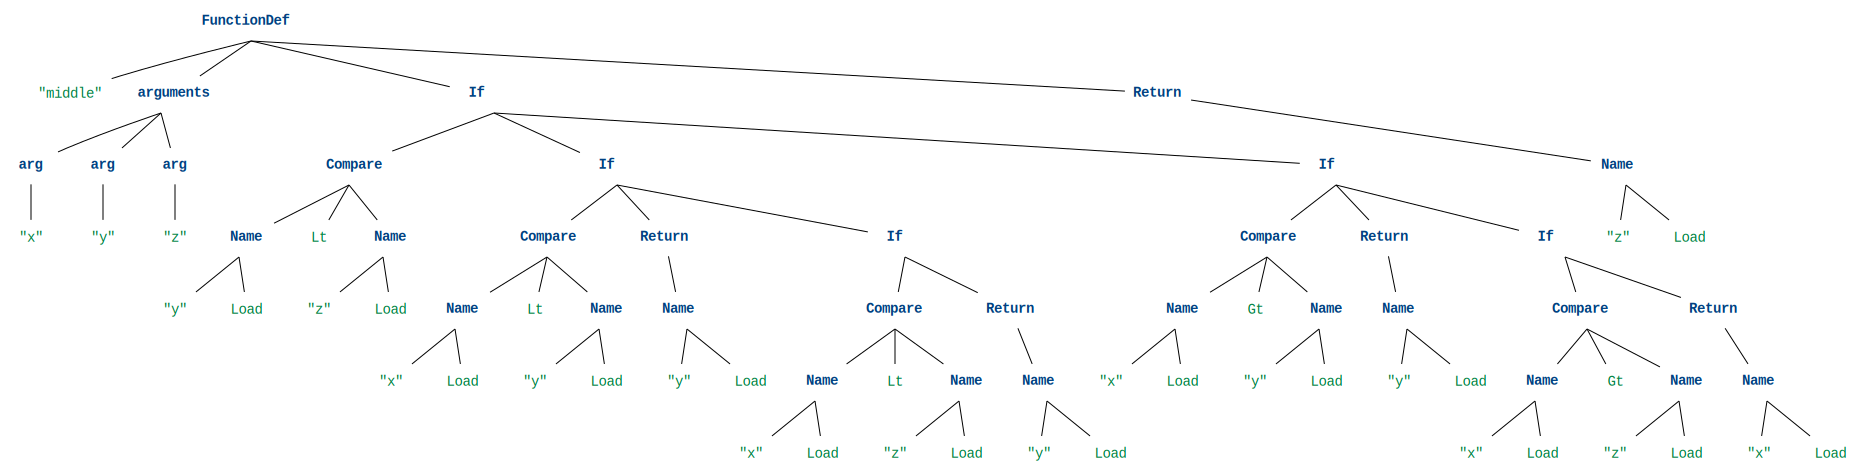

In [36]:
show_ast(middle_tree())

 You see that it consists of one function definition (`FunctionDef`) with three `arguments` and two statements – one `If` and one `Return`. Each `If` subtree has three branches – one for the condition (`test`), one for the body to be executed if the condition is true (`body`), and one for the `else` case (`orelse`). The `body` and `orelse` branches again are lists of statements.

An AST can also be shown as text, which is more compact, yet reveals more information. `ast.dump()` gives not only the class names of elements, but also how they are constructed – actually, the whole expression can be used to construct an AST.

In [37]:
print(ast.dump(middle_tree()))

Module(body=[FunctionDef(name='middle', args=arguments(posonlyargs=[], args=[arg(arg='x', annotation=None, type_comment=None), arg(arg='y', annotation=None, type_comment=None), arg(arg='z', annotation=None, type_comment=None)], vararg=None, kwonlyargs=[], kw_defaults=[], kwarg=None, defaults=[]), body=[If(test=Compare(left=Name(id='y', ctx=Load()), ops=[Lt()], comparators=[Name(id='z', ctx=Load())]), body=[If(test=Compare(left=Name(id='x', ctx=Load()), ops=[Lt()], comparators=[Name(id='y', ctx=Load())]), body=[Return(value=Name(id='y', ctx=Load()))], orelse=[If(test=Compare(left=Name(id='x', ctx=Load()), ops=[Lt()], comparators=[Name(id='z', ctx=Load())]), body=[Return(value=Name(id='y', ctx=Load()))], orelse=[])])], orelse=[If(test=Compare(left=Name(id='x', ctx=Load()), ops=[Gt()], comparators=[Name(id='y', ctx=Load())]), body=[Return(value=Name(id='y', ctx=Load()))], orelse=[If(test=Compare(left=Name(id='x', ctx=Load()), ops=[Gt()], comparators=[Name(id='z', ctx=Load())]), body=[Retu

This is the path to the first `return` statement:

In [38]:
ast.dump(middle_tree().body[0].body[0].body[0].body[0])

"Return(value=Name(id='y', ctx=Load()))"

### Picking Statements

For our mutation operators, we want to use statements from the program itself. Hence, we need a means to find those very statements. The `StatementVisitor` class iterates through an AST, adding all statements to its `statements` list it finds in function definitions. To do so, it subclasses the Python `ast` `NodeVisitor` class, described in the [official Python `ast` reference](http://docs.python.org/3/library/ast).

In [39]:
from ast import NodeVisitor

In [40]:
class StatementVisitor(NodeVisitor):
    """Visit all statements within function defs in an AST"""
    def __init__(self):
        self.statements = []
        self.func_name = None
        self.statements_seen = set()
        super().__init__()

    def add_statements(self, node, attr):
        elems = getattr(node, attr, [])
        if not isinstance(elems, list):
            elems = [elems]

        for elem in elems:
            stmt = (elem, self.func_name)
            if stmt in self.statements_seen:
                continue

            self.statements.append(stmt)
            self.statements_seen.add(stmt)

    def visit_node(self, node):
        # Any node other than the ones listed below
        self.add_statements(node, 'body')
        self.add_statements(node, 'orelse')

    def visit_Module(self, node):
        # Module children are defs, classes and globals - don't add
        super().generic_visit(node)

    def visit_ClassDef(self, node):
        # Class children are defs and globals - don't add
        super().generic_visit(node)

    def generic_visit(self, node):
        self.visit_node(node)
        super().generic_visit(node)

    def visit_FunctionDef(self, node):
        if self.func_name is None:
            self.func_name = node.name

        self.visit_node(node)
        super().generic_visit(node)
        self.func_name = None

    def visit_AsyncFunctionDef(self, node):
        return self.visit_FunctionDef(self, node)

The function `all_statements()` returns all statements in the given AST `tree`. If an `ast` class `tp` is given, it only returns instances of that class.

In [41]:
def all_statements_and_functions(tree, tp=None):
    visitor = StatementVisitor()
    visitor.visit(tree)
    statements = visitor.statements
    if tp is not None:
        statements = [s for s in statements if isinstance(s[0], tp)]

    return statements

In [42]:
def all_statements(tree, tp=None):
    return [stmt for stmt, func_name in all_statements_and_functions(tree, tp)]

Here are all the `return` statements in `middle()`:

In [43]:
all_statements(middle_tree(), ast.Return)

In [44]:
all_statements_and_functions(middle_tree(), ast.If)

[(<_ast.If at 0x7fcd5c025a30>, 'middle'),
 (<_ast.If at 0x7fcd5c025b20>, 'middle'),
 (<_ast.If at 0x7fcd5c025bb0>, 'middle'),
 (<_ast.If at 0x7fcd5c025940>, 'middle'),
 (<_ast.If at 0x7fcd5c025d90>, 'middle')]

We can randomly pick an element:

In [45]:
import random

In [46]:
random_node = random.choice(all_statements(middle_tree()))
astor.to_source(random_node)

'return y\n'

### Mutating Statements

The main part in mutation, however, is to actually mutate the code of the program under test. To this end, we introduce a `StatementMutator` class – a subclass of `NodeTransformer`, described in the [official Python `ast` reference](http://docs.python.org/3/library/ast).

The constructor provides various keyword arguments to configure the mutator.

In [47]:
from ast import NodeTransformer

In [48]:
import copy

In [49]:
class StatementMutator(NodeTransformer):
    """Mutate statements in an AST for automated repair."""

    def __init__(self, suspiciousness_func=None, source=None, log=False):
        """Constructor.
`suspiciousness_func` is a function that takes a location
  (function, line_number) and returns a suspiciousness value
  between 0 and 1.0. If not given, all locations get the
  same suspiciousness of 1.0.
`source` is a list of statements to choose from."""

        super().__init__()
        self.log = log

        if suspiciousness_func is None:
            def suspiciousness_func(location):
                return 1.0

        self.suspiciousness_func = suspiciousness_func

        if source is None:
            source = []
        self.source = source
#        print(f"Set source to {self.source}")

        if self.log > 1:
            for i, node in enumerate(self.source):
                print(f"Source for repairs #{i}:")
                print_content(astor.to_source(node), '.py')
                print()
                print()

        self.mutations = 0

#### Choosing Suspicious Statements to Mutate

We start with deciding which AST nodes to mutate. The method `node_suspiciousness()` returns the suspiciousness for a given node, by invoking the suspiciousness function `suspiciousness_func` given during initialization.

In [50]:
import warnings

In [51]:
class StatementMutator(StatementMutator):
    def node_suspiciousness(self, stmt, func_name):
        if not hasattr(stmt, 'lineno'):
            warnings.warn(f"{self.format_node(stmt)}: Expected line number")
            return 0.0

        suspiciousness = self.suspiciousness_func((func_name, stmt.lineno))
        if suspiciousness is None:  # not executed
            return 0.0

        return suspiciousness

The method `node_to_be_mutated()` picks a node (statement) to be mutated. It determines the suspiciousness of all statements, and invokes `random.choices()`, using the suspiciousness as weight. Unsuspicious statements (with zero weight) will not be chosen.

In [52]:
class StatementMutator(StatementMutator):
    def node_to_be_mutated(self, tree):
        statements = all_statements_and_functions(tree)
        assert len(statements) > 0, "No statements"

        weights = [self.node_suspiciousness(stmt, func_name) 
                   for stmt, func_name in statements]
        stmts = [stmt for stmt, func_name in statements]

        if self.log > 1:
            print("Weights:")
            for i, stmt in enumerate(statements):
                node, func_name = stmt
                print(f"{weights[i]:.2} {self.format_node(node)}")

        if sum(weights) == 0.0:
            # No suspicious line
            return random.choice(stmts)
        else:
            return random.choices(stmts, weights=weights)[0]

#### Choosing a Mutation Method

The method `visit()` is invoked on all nodes. For nodes marked with a `mutate_me` attribute, it randomly chooses a mutation method (`choose_op()`) and then invokes it on the node.

According to the rules of `NodeTransformer`, the mutation method can return

* a new node or a list of nodes, replacing the current node;
* `None`, deleting it; or
* the node itself, keeping things as they are.

In [53]:
import re

In [54]:
RE_SPACE = re.compile(r'[ \t\n]+')

In [55]:
class StatementMutator(StatementMutator):
    def choose_op(self):
        return random.choice([self.insert, self.swap, self.delete])

    def visit(self, node):
        super().visit(node)  # Visits (and transforms?) children

        if not node.mutate_me:
            return node
        
        old_node = node
        op = self.choose_op()
        new_node = op(node)
        self.mutations += 1

        if self.log:
            print(f"{node.lineno:4}:default_{op.__name__ + ':':7} "
                  f"{self.format_node(old_node)} "
                  f"becomes {self.format_node(new_node)}")

        return new_node

#### Swapping Statements

Our first mutator is `swap()`, which replaces the current node NODE by a random node found in `source` (using a newly defined `choose_statement()`).

As a rule of thumb, we try to avoid inserting entire subtrees with all attached statements; and try to respect only the first line of a node. If the new node has the form 

```python
if P:
    BODY
```

we thus only insert 

```python
if P: 
    pass
```

since the statements in BODY have a later chance to get inserted. The same holds for all constructs that have a BODY, i.e. `while`, `for`, `try`, `with`, and more.

In [56]:
class StatementMutator(StatementMutator):
    def choose_statement(self):
        return copy.deepcopy(random.choice(self.source))

In [57]:
class StatementMutator(StatementMutator):
    def swap(self, node):
        """Replace `node` with a random node from `source`"""
        new_node = self.choose_statement()

        if isinstance(new_node, ast.stmt):
            # The source `if P: X` is added as `if P: pass`
            if hasattr(new_node, 'body'):
                new_node.body = [ast.Pass()]
            if hasattr(new_node, 'orelse'):
                new_node.orelse = []
            if hasattr(new_node, 'finalbody'):
                new_node.finalbody = []

        # ast.copy_location(new_node, node)
        return new_node

#### Inserting Statements

Our next mutator is `insert()`, which randomly chooses some node from `source` and inserts it after the current node NODE. (If NODE is a `return` statement, then we insert the new node _before_ NODE.)

If the statement to be inserted has the form

```python
if P:
    BODY
```

we only insert the "header" of the `if`, resulting in

```python
if P: 
    NODE
```

Again, this applies to all constructs that have a BODY, i.e. `while`, `for`, `try`, `with`, and more.

In [58]:
class StatementMutator(StatementMutator):
    def insert(self, node):
        """Insert a random node from `source` after `node`"""
        new_node = self.choose_statement()

        if isinstance(new_node, ast.stmt) and hasattr(new_node, 'body'):
            # Inserting `if P: X` as `if P:`
            new_node.body = [node]
            if hasattr(new_node, 'orelse'):
                new_node.orelse = []
            if hasattr(new_node, 'finalbody'):
                new_node.finalbody = []
      #      ast.copy_location(new_node, node)
            return new_node

        # Only insert before `return`, not after it
        if isinstance(node, ast.Return):
            if isinstance(new_node, ast.Return):
                return new_node
            else:
                return [new_node, node]

        return [node, new_node]

#### Deleting Statements

Our last mutator is `delete()`, which deletes the current node NODE. The standard case is to replace NODE by a `pass` statement.

If the statement to be deleted has the form

```python
if P:
    BODY
```

we only delete the "header" of the `if`, resulting in

```python
BODY
```

Again, this applies to all constructs that have a BODY, i.e. `while`, `for`, `try`, `with`, and more; it also selects a random branch, including `else` branches.

In [59]:
class StatementMutator(StatementMutator):
    def delete(self, node):
        """Delete `node`."""

        branches = [attr for attr in ['body', 'orelse', 'finalbody']
                    if hasattr(node, attr) and getattr(node, attr)]
        if branches:
            # Replace `if P: S` by `S`
            branch = random.choice(branches)
            new_node = getattr(node, branch)
            return new_node

        if isinstance(node, ast.stmt):
            # Avoid empty bodies; make this a `pass` statement
            new_node = ast.Pass()
            ast.copy_location(new_node, node)
            return new_node

        return None  # Just delete

In [60]:
from bookutils import quiz

In [61]:
quiz("Why are statements replaced by `pass` rather than deleted?",
     [
         "Because `if P: pass` is valid Python, while `if P:` is not",
         "Because in Python, bodies for `if`, `while`, etc. cannot be empty",
         "Because a `pass` node makes a target for future mutations",
         "Because it causes the tests to pass"
     ],
     [3 ^ n for n in range(3)]
    )

Indeed, Python's `compile()` will fail if any of the bodies is an empty list. Also, it leaves us a statement that can be evolved further.

#### Helpers

For logging purposes, we introduce a helper function `format_node()` that returns a short string representation of the node.

In [62]:
class StatementMutator(StatementMutator):
    NODE_MAX_LENGTH = 40

    def format_node(self, node):
        """Return a string representation for `node`."""
        if node is None:
            return "None"

        if isinstance(node, list):
            return "; ".join(self.format_node(elem) for elem in node)

        s = RE_SPACE.sub(' ', astor.to_source(node)).strip()
        if len(s) > self.NODE_MAX_LENGTH - len("..."):
            s = s[:self.NODE_MAX_LENGTH] + "..."
        return repr(s)

#### All Together

Let us now create the main entry point, which is `mutate()`. It picks the node to be mutated and marks it with a `mutate_me` attribute. By calling `visit()`, it then sets off the `NodeTransformer` transformation.

In [63]:
class StatementMutator(StatementMutator):
    def mutate(self, tree):
        """Mutate the given AST `tree` in place. Return mutated tree."""

        assert isinstance(tree, ast.AST)

        new_tree = copy.deepcopy(tree)

        if not self.source:
            self.source = all_statements(new_tree)

        for node in ast.walk(new_tree):
            node.mutate_me = False

        node = self.node_to_be_mutated(new_tree)
        node.mutate_me = True

        self.mutations = 0

        new_tree = self.visit(new_tree)

        if self.mutations == 0:
            warnings.warn("No mutations found")

        ast.fix_missing_locations(new_tree)
        return new_tree

Here are a number of transformations applied by `StatementMutator`:

In [64]:
mutator = StatementMutator(log=True)
for i in range(10):
    new_tree = mutator.mutate(middle_tree())

   9:default_insert: 'return y' becomes 'return y'
   8:default_insert: 'if x > y: return y elif x > z: return x...' becomes 'if x < y: if x > y: return y elif x > z:...'
  12:default_insert: 'return z' becomes 'if y < z: return z'
   3:default_swap:   'if x < y: return y elif x < z: return y...' becomes 'return x'
   3:default_swap:   'if x < y: return y elif x < z: return y...' becomes 'return z'
   3:default_swap:   'if x < y: return y elif x < z: return y...' becomes 'return x'
  11:default_swap:   'return x' becomes 'return y'
  10:default_insert: 'if x > z: return x' becomes 'if x > z: return x'; 'return z'
  12:default_delete: 'return z' becomes 'pass'
   8:default_swap:   'if x > y: return y elif x > z: return x...' becomes 'if y < z: pass'


This is the effect of the last mutator applied on `middle`:

In [65]:
print_content(astor.to_source(new_tree), '.py')

def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return y
    elif y < z:
        pass
    return z

## Fitness

Now that we can apply random mutations to code, let us find out how good these mutations are. Given our test suites for `middle`, we can check for a given code candidate how many of the previously passing test cases it passes, and how many of the failing test cases it passes. The more tests pass, the higher the _fitness_ of the candidate.

Not all passing tests have the same value, though. We want to prevent _regressions_ – that is, having a fix that breaks a previously passing test. The values of `WEIGHT_PASSING` and `WEIGHT_FAILING` set the relative weight (or importance) of passing vs. failing tests; we see that keeping passing tests passing is far more important then fixing failing tests.

In [66]:
WEIGHT_PASSING = 0.99
WEIGHT_FAILING = 0.01

In [67]:
def middle_fitness(tree):
    """Compute fitness of a `middle()` candidate given in `tree`"""
    original_middle = middle

    try:
        code = compile(tree, '<fitness>', 'exec')
    except ValueError:
        return 0  # Compilation error

    exec(code, globals())

    passing_passed = 0
    failing_passed = 0

    # Test how many of the passing runs pass
    for x, y, z in MIDDLE_PASSING_TESTCASES:
        try:
            middle_test(x, y, z)
            passing_passed += 1
        except AssertionError:
            pass

    passing_ratio = passing_passed / len(MIDDLE_PASSING_TESTCASES)

    # Test how many of the failing runs pass
    for x, y, z in MIDDLE_FAILING_TESTCASES:
        try:
            middle_test(x, y, z)
            failing_passed += 1
        except AssertionError:
            pass

    failing_ratio = failing_passed / len(MIDDLE_FAILING_TESTCASES)

    fitness = (WEIGHT_PASSING * passing_ratio +
               WEIGHT_FAILING * failing_ratio)

    globals()['middle'] = original_middle
    return fitness

Our faulty `middle()` program has a fitness of `WEIGHT_PASSING` (99%), because it passes all the passing tests (but none of the failing ones).

In [68]:
middle_fitness(middle_tree())

0.99

Our "sort of fixed" version of `middle()` gets a much lower fitness:

In [69]:
middle_fitness(ast.parse("def middle(x, y, z): return x"))

0.4159

In the [chapter on statistical debugging](StatisticalDebugger), we also defined a fixed version of `middle()`. This gets a fitness of 1.0, passing all tests. (We won't use this fixed version for automated repairs.)

In [70]:
from StatisticalDebugger import middle_fixed

In [71]:
middle_fixed_source = \
    inspect.getsource(middle_fixed).replace('middle_fixed', 'middle').strip()

In [72]:
middle_fitness(ast.parse(middle_fixed_source))

1.0

## Population

We now set up a _population_ of fix candidates to evolve over time.  A higher population size will yield more candidates to check, but also need more time to test; a lower population size will yield fewer candidates, but allow for more evolution steps.  We choose a population size of 40 (from \cite{LeGoues2012}). 

In [73]:
POPULATION_SIZE = 60
middle_mutator = StatementMutator()

In [74]:
MIDDLE_POPULATION = [middle_tree()] + \
    [middle_mutator.mutate(middle_tree()) for i in range(POPULATION_SIZE - 1)]

We sort the fix candidates according to their fitness. This actually runs all tests on all candidates.

In [75]:
MIDDLE_POPULATION.sort(key=middle_fitness, reverse=True)

The candidate with the highest fitness is still our original (faulty) `middle()` code:

In [76]:
print(astor.to_source(MIDDLE_POPULATION[0]),
      middle_fitness(MIDDLE_POPULATION[0]))

def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return y
    elif x > y:
        return y
    elif x > z:
        return x
    return z
 0.99


At the other end of the spectrum, the candidate with the lowest fitness has some vital functionality removed:

In [77]:
print(astor.to_source(MIDDLE_POPULATION[-1]),
      middle_fitness(MIDDLE_POPULATION[-1]))

def middle(x, y, z):
    if x < y:
        return y
    elif x < z:
        return y
    return z
 0.3564


## Evolution

To evolve our population of candidates, we fill up the population with mutations created from the population, using a `StatementMutator` as described above to create these mutations. Then we reduce the population to its original size, keeping the fittest candidates.

In [78]:
def evolve_middle():
    global MIDDLE_POPULATION

    source = all_statements(middle_tree())
    mutator = StatementMutator(source=source)

    n = len(MIDDLE_POPULATION)

    offspring = []
    while len(offspring) < n:
        parent = random.choice(MIDDLE_POPULATION)
        offspring.append(mutator.mutate(parent))

    MIDDLE_POPULATION += offspring
    MIDDLE_POPULATION.sort(key=middle_fitness, reverse=True)
    MIDDLE_POPULATION = MIDDLE_POPULATION[:n]

This is what happens when evolving our population for the first time; the original source is still our best candidate.

In [79]:
evolve_middle()

In [80]:
tree = MIDDLE_POPULATION[0]
print(astor.to_source(tree), middle_fitness(tree))

def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return y
    elif x > y:
        return y
    elif x > z:
        return x
    return z
 0.99


However, nothing keeps us from evolving for a few generations more...

In [81]:
for i in range(50):
    evolve_middle()
    best_middle_tree = MIDDLE_POPULATION[0]
    fitness = middle_fitness(best_middle_tree)
    print(f"\rIteration {i}: fitness = {fitness}  ", end="")
    if fitness >= 1.0:
        break

Iteration 0: fitness = 1.0  

Success! We find a candidate that actually passes all tests, including the failing ones. Here is the candidate:

In [82]:
print_content(astor.to_source(best_middle_tree), '.py', start_line_number=1)

 1  def middle(x, y, z):
 2      if y < z:
 3          if x < y:
 4              return y
 5          elif x < z:
 6              return x
 7      elif x > y:
 8          return y
 9      elif x > z:
10          if x > z:
11              return x
12      return z

... and yes, it passes all tests:

In [83]:
original_middle = middle
code = compile(best_middle_tree, '<string>', 'exec')
exec(code, globals())

for x, y, z in MIDDLE_PASSING_TESTCASES + MIDDLE_FAILING_TESTCASES:
    middle_test(x, y, z)

middle = original_middle

As the code is already validated by hundreds of test cases, it is very valuable for the programmer. Even if the programmer decides not to use the code as is, the location gives very strong hints on which code to examine and where to apply a fix.

However, a closer look at our fix candidate shows that there is some amount of redundancy – that is, superfluous statements.

In [84]:
quiz("Some of the lines in our fix candidate are redundant. Which are these?",
    [
        "Line 3: `if x < y`",
        "Line 4: `if x > z`",
        "Line 5: `return x`",
        "Line 13: `return z`"
    ],
    [eval(chr(100 - x)) for x in [49, 50]]
    )

## Simplifying

As demonstrated in the chapter on [reducing failure-inducing inputs](DeltaDebugger.ipynb), we can use delta debugging on code to get rid of these superfluous statements.

The trick for simplification is to have the test function (`test_middle_lines()`) declare a fitness of 1.0 as a "failure". Delta debugging will then simplify the input as long as the "failure" (and hence the maximum fitness obtained) persists.

In [85]:
from DeltaDebugger import DeltaDebugger

In [86]:
middle_lines = astor.to_source(best_middle_tree).strip().split('\n')

In [87]:
def test_middle_lines(lines):
    source = "\n".join(lines)
    tree = ast.parse(source)
    assert middle_fitness(tree) < 1.0  # "Fail" only while fitness is 1.0

In [88]:
with DeltaDebugger() as dd:
    test_middle_lines(middle_lines)

In [89]:
reduced_lines = dd.min_args()['lines']

In [90]:
# assert len(reduced_lines) < len(middle_lines)

In [91]:
reduced_source = "\n".join(reduced_lines)

In [92]:
repaired_source = astor.to_source(ast.parse(reduced_source))  # normalize
print_content(repaired_source, '.py')

def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return x
    elif x > y:
        return y
    elif x > z:
        return x
    return z

Success! Delta Debugging has eliminated the superfluous statements. We can present the difference to the original as a patch:

In [93]:
original_source = astor.to_source(ast.parse(middle_source))  # normalize

In [94]:
from ChangeDebugger import diff, print_patch  # minor dependency

In [95]:
for patch in diff(original_source, repaired_source):
    print_patch(patch)

@@ -87,37 +87,37 @@
  x < z:

-            return y

+            return x

     elif

We can present this patch to the programmer, who will then immediately know what to fix in the `middle()` code.

## Crossover

So far, we have only applied one kind of genetic operators – mutation. There is a second one, though, also inspired by natural selection. 

The *crossover* operation mutation two strands of genes, as illustrated in the following picture. We have two parents (red and blue), each as a sequence of genes. To create "crossed" chilren, we pick a _crossover point_ and exchange the strands at this very point:

![](https://upload.wikimedia.org/wikipedia/commons/thumb/5/56/OnePointCrossover.svg/500px-OnePointCrossover.svg.png)

We implement a `CrossoverOperator` class that implements such an operation on two randomly chosen statement lists of two programs. It is used as

```python
crossover = CrossoverOperator()
crossover.crossover(tree_p1, tree_p2)
```

where `tree_p1` and `tree_p2` are two ASTs that are changed in place.

### Excursion: Implementing Crossover

#### Crossing Statement Lists

Applied on programs, a crossover mutation takes two parents and "crosses" a list of statements. As an example, if our "parents" `p1()` and `p2()` are defined as follows:

In [96]:
def p1():
    a = 1
    b = 2
    c = 3

In [97]:
def p2():
    x = 1
    y = 2
    z = 3

Then a crossover operation would produce one child with a body

```python
a = 1
y = 2
z = 3
```

and another child with a body

```python
x = 1
b = 2
c = 3
```

We can easily implement this in a `CrossoverOperator` class in a method `cross_bodies()`.

In [98]:
class CrossoverOperator:
    def __init__(self, log=False):
        """Constructor. If `log` is set, turn on logging."""
        self.log = log

    def cross_bodies(self, body_1, body_2):
        """CrossoverOperator the statement lists `body_1` x `body_2`.
        Return new lists.
        """

        assert isinstance(body_1, list)
        assert isinstance(body_2, list)

        crossover_point_1 = len(body_1) // 2
        crossover_point_2 = len(body_2) // 2
        return (body_1[:crossover_point_1] + body_2[crossover_point_2:],
                body_2[:crossover_point_2] + body_1[crossover_point_1:])

Here's the `CrossoverOperatorMutator` applied on `p1` and `p2`:

In [99]:
tree_p1 = ast.parse(inspect.getsource(p1))
tree_p2 = ast.parse(inspect.getsource(p2))

In [100]:
body_p1 = tree_p1.body[0].body
body_p2 = tree_p2.body[0].body
body_p1

In [101]:
crosser = CrossoverOperator()
tree_p1.body[0].body, tree_p2.body[0].body = crosser.cross_bodies(body_p1, body_p2)

In [102]:
print_content(astor.to_source(tree_p1), '.py')

def p1():
    a = 1
    y = 2
    z = 3

In [103]:
print_content(astor.to_source(tree_p2), '.py')

def p2():
    x = 1
    b = 2
    c = 3

#### Applying Crossover on Programs

Applying the crossover operation on arbitrary programs is a bit more complex, though. We first have to _find_ lists of statements that we a actually can cross over. The `can_cross()` method returns True if we have a list of statements that we can cross. Python modules and classes are excluded, because changing the ordering of definitions will not have much impact on the program.

In [104]:
class CrossoverOperator(CrossoverOperator):
    # In modules and class defs, the ordering of elements does not matter (much)
    SKIP_LIST = {ast.Module, ast.ClassDef}

    def can_cross(self, tree, body_attr='body'):
        if any(isinstance(tree, cls) for cls in self.SKIP_LIST):
            return False

        body = getattr(tree, body_attr, [])
        return body and len(body) >= 2

Here comes our method `crossover_attr()` which searches for crossover possibilities. It takes to ASTs `t1` and `t2` and an attribute (typically `'body'`) and retrieves the attribute lists $l_1$ (from `t1.<attr>`) and $l_2$ (from `t2.<attr>`).

If $l_1$ and $l_2$ can be crossed, it crosses them, and is done. Otherwise

* If there is a pair of elements $e_1 \in l_1$ and $e_2 \in l_2$ that has the same name – say, functions of the same name –, it applies itself to $e_1$ and $e_2$.
* Otherwise, it creates random pairs of elements $e_1 \in l_1$ and $e_2 \in l_2$ and applies itself on these very pairs.

`crossover_attr()` changes `t1` and `t2` in place and returns True if a crossover was found; it returns False otherwise.

In [105]:
class CrossoverOperator(CrossoverOperator):
    def crossover_attr(self, t1, t2, body_attr):
        """CrossoverOperator the bodies `body_attr` of two trees `t1` and `t2`.
        Return True if successful."""
        assert isinstance(t1, ast.AST)
        assert isinstance(t2, ast.AST)
        assert isinstance(body_attr, str)

        if not getattr(t1, body_attr, None) or not getattr(t2, body_attr, None):
            return False

        if self.crossover_branches(t1, t2):
            return t1, t2

        if self.log > 1:
            print(f"Checking {t1}.{body_attr} x {t2}.{body_attr}")

        body_1 = getattr(t1, body_attr)
        body_2 = getattr(t2, body_attr)

        # If both trees have the attribute, we can cross their bodies
        if self.can_cross(t1, body_attr) and self.can_cross(t2, body_attr):
            if self.log:
                print(f"Crossing {t1}.{body_attr} x {t2}.{body_attr}")

            new_body_1, new_body_2 = self.cross_bodies(body_1, body_2)
            setattr(t1, body_attr, new_body_1)
            setattr(t2, body_attr, new_body_2)
            return True

        # Strategy 1: Find matches in class/function of same name
        for child_1 in body_1:
            if hasattr(child_1, 'name'):
                for child_2 in body_2:
                    if (hasattr(child_2, 'name') and
                           child_1.name == child_2.name):
                        if self.crossover_attr(child_1, child_2, body_attr):
                            return True

        # Strategy 2: Find matches anywhere
        for child_1 in random.sample(body_1, len(body_1)):
            for child_2 in random.sample(body_2, len(body_2)):
                if self.crossover_attr(child_1, child_2, body_attr):
                    return True

        return False

We have a special case for `if` nodes, where we can cross their body and `else` branches.

In [106]:
class CrossoverOperator(CrossoverOperator):
    def crossover_branches(self, t1, t2):
        """Special case:
        `t1` = `if P: S1 else: S2` x `t2` = `if P': S1' else: S2'`
        becomes
        `t1` = `if P: S2' else: S1'` and `t2` = `if P': S2 else: S1`
        Returns True if successful.
        """
        assert isinstance(t1, ast.AST)
        assert isinstance(t2, ast.AST)

        if (getattr(t1, 'body', None) and getattr(t1, 'orelse', None) and
            getattr(t2, 'body', None) and getattr(t2, 'orelse', None)):

            if self.log:
                print(f"Crossing branches {t1} x {t2}")

            t1.body, t1.orelse, t2.body, t2.orelse = \
                t2.orelse, t2.body, t1.orelse, t1.body
            return True

        return False

The method `crossover()` is the main entry point. It checks for the special `if` case as described above; if not, it searches for possible crossover points. It raises `CrossoverError` if not successful.

In [107]:
class CrossoverOperator(CrossoverOperator):
    def crossover(self, t1, t2):
        """Do a crossover of ASTs `t1` and `t2`.
        Raises `CrossoverError` if no crossover is found."""
        assert isinstance(t1, ast.AST)
        assert isinstance(t2, ast.AST)

        for body_attr in ['body', 'orelse', 'finalbody']:
            if self.crossover_attr(t1, t2, body_attr):
                return t1, t2

        raise CrossoverError("No crossover found")

In [108]:
class CrossoverError(ValueError):
    pass

### End of Excursion

### Crossover in Action

Let us put our `CrossoverOperator` in action. Here is a test case for crossover, involving more deeply nested structures:

In [109]:
def p1():
    if True:
        print(1)
        print(2)
        print(3)

In [110]:
def p2():
    if True:
        print(a)
        print(b)
    else:
        print(c)
        print(d)

We invoke the `crossover()` method with two ASTs from `p1` and `p2`:

In [111]:
crossover = CrossoverOperator()
tree_p1 = ast.parse(inspect.getsource(p1))
tree_p2 = ast.parse(inspect.getsource(p2))
crossover.crossover(tree_p1, tree_p2);

Here is the crossed offspring, mixing statement lists of `p1` and `p2`:

In [112]:
print_content(astor.to_source(tree_p1), '.py')

def p1():
    if True:
        print(1)
        print(b)

In [113]:
print_content(astor.to_source(tree_p2), '.py')

def p2():
    if True:
        print(a)
        print(2)
        print(3)
    else:
        print(c)
        print(d)

Here is our special case for `if` nodes in action, crossing our `middle()` tree with `p2`.

In [114]:
middle_t1, middle_t2 = crossover.crossover(middle_tree(),
                                          ast.parse(inspect.getsource(p2)))

We see how the resulting offspring encompasses elements of both sources:

In [115]:
print_content(astor.to_source(middle_t1), '.py')

def middle(x, y, z):
    if y < z:
        print(c)
        print(d)
    else:
        print(a)
        print(b)
    return z

In [116]:
print_content(astor.to_source(middle_t2), '.py')

def p2():
    if True:
        if x > y:
            return y
        elif x > z:
            return x
    elif x < y:
        return y
    elif x < z:
        return y

## A Repairer Class

So far, we have applied all our techniques on the `middle()` program only. Let us now create a `Repairer` class that applies automatic program repair on arbitrary Python programs. The idea is that you can apply it on some statistical debugger, for which you have gathered passing and failing test cases, and then invoke its `repair()` method to find a "best" fix candidate:

```python
debugger = OchiaiDebugger()
with debugger:
    <passing test>
with debugger:
    <failing test>
...
repairer = Repairer(debugger)
repairer.repair()
```

### Excursion: Implementing Repairer

The main argument to the `Repairer` constructor is the `debugger` to get information from. On top of that, it also allows to customize the classes used for mutation, crossover, and reduction. Setting `targets` allows to define a set of functions to repair; setting `sources` allows to set a set of sources to take repairs from. The constructor then sets up the environment for running tests and repairing, as described below.

In [117]:
class Repairer():
    def __init__(self, debugger, targets=None, sources=None, log=False,
                 mutator_class=StatementMutator,
                 crossover_class=CrossoverOperator,
                 reducer_class=DeltaDebugger,
                 globals=None):
        """Constructor.
`debugger`: a `DifferenceDebugger` to take tests and coverage from.
`targets`: a list of functions/modules to be repaired.
    (default: the covered functions in `debugger`, except tests)
`sources`: a list of functions/modules to take repairs from.
    (default: same as `targets`)
`globals`: if given, a `globals()` dict for executing targets
    (default: `globals()` of caller)"""

        assert isinstance(debugger, DifferenceDebugger)
        self.debugger = debugger
        self.log = log
        
        if targets is None:
            targets = self.default_functions()
        if not targets:
            raise ValueError("No targets to repair")

        if sources is None:
            sources = self.default_functions()
        if not sources:
            raise ValueError("No sources to take repairs from")

        if self.debugger.function() is None:
            raise ValueError("Multiple entry points observed")

        self.target_tree = self.parse(targets)
        self.source_tree = self.parse(sources)

        self.log_tree("Target code to be repaired:", self.target_tree)
        if ast.dump(self.target_tree) != ast.dump(self.source_tree):
            self.log_tree("Source code to take repairs from:", 
                          self.source_tree)

        self.fitness_cache = {}

        self.mutator = \
            mutator_class(
                source=all_statements(self.source_tree),
                suspiciousness_func=self.debugger.suspiciousness,
                log=(self.log >= 3))
        self.crossover = crossover_class(log=(self.log >= 3))
        self.reducer = reducer_class(log=(self.log >= 3))

        if globals is None:
            globals = self.caller_globals()
        self.globals = globals

#### Helper Functions

The constructor uses a number of helper functions to create its environment.

When we access or execute functions, we do so in the  caller's environment, not ours. The `caller_globals()` method from `StackInspector` acts as replacement for `globals()`.

In [118]:
from Slicer import StackInspector  # minor dependency

We use multiple inheritance to include all of the functions of `StackInspector`.

In [119]:
class Repairer(Repairer, StackInspector):
    pass

In [120]:
class Repairer(Repairer):
    def getsource(self, item):
        """Get the source for `item`. Can also be a string."""
        if isinstance(item, str):
            item = self.globals[item]
        return inspect.getsource(item)

In [121]:
class Repairer(Repairer):
    def default_functions(self):
        """Return the set of functions to be repaired.
        Functions whose names start or end in `test` are excluded."""
        def is_test(name):
            return name.startswith('test') or name.endswith('test')

        return [func for func in self.debugger.covered_functions()
                if not is_test(func.__name__)]

In [122]:
class Repairer(Repairer):
    def log_tree(self, description, tree):
        """Print out `tree` as source code prefixed by `description`."""
        if self.log:
            print(description)
            print_content(astor.to_source(tree), '.py')
            print()
            print()

In [123]:
class Repairer(Repairer):
    def parse(self, items):
        """Read in a set of items into a single tree"""
        tree = ast.parse("")
        for item in items:
            if isinstance(item, str):
                item = self.globals[item]

            item_lines, item_first_lineno = inspect.getsourcelines(item)

            try:
                item_tree = ast.parse("".join(item_lines))
            except IndentationError:
                # inner function or likewise
                warnings.warn(f"Can't parse {item.__name__}")
                continue

            ast.increment_lineno(item_tree, item_first_lineno - 1)
            tree.body += item_tree.body

        return tree

#### Running Tests

Now that we have set the environment for `Repairer`, we can implement one step of automatic repair after the other. The method `run_test_set()` runs the given `test_set` (`DifferenceDebugger.PASS` or `DifferenceDebugger.FAIL`), returning the number of passed tests. If `validate` is set, it checks whether the outcomes are as expected.

In [124]:
class Repairer(Repairer):
    def run_test_set(self, test_set, validate=False):
        """Run given `test_set`
        (`DifferenceDebugger.PASS` or `DifferenceDebugger.FAIL`).
        If `validate` is set, check expectations.
        Return number of passed tests."""
        passed = 0
        collectors = self.debugger.collectors[test_set]     
        function = self.debugger.function()
        # FIXME: function may have been redefined

        for c in collectors:
            if self.log >= 4:
                print(f"Testing {c.id()}...", end="")

            try:
                function(**c.args())
            except Exception as err:
                if self.log >= 4:
                    print(f"failed ({err.__class__.__name__})")

                if validate and test_set == self.debugger.PASS:
                    raise err.__class__(
                        f"{c.id()} should have passed, but failed")
                continue

            passed += 1
            if self.log >= 4:
                print("passed")

            if validate and test_set == self.debugger.FAIL:
                raise FailureNotReproducedError(
                    f"{c.id()} should have failed, but passed")

        return passed

In [125]:
class FailureNotReproducedError(ValueError):
    pass

Here is how we use `run_tests_set()`:

In [126]:
repairer = Repairer(middle_debugger)
assert repairer.run_test_set(middle_debugger.PASS) == \
    len(MIDDLE_PASSING_TESTCASES)
assert repairer.run_test_set(middle_debugger.FAIL) == 0

The method `run_tests()` runs passing and failing tests, weighing the passed testcases to obtain the overall fitness.

In [127]:
import PreprocessWorker

In [241]:
class Repairer(Repairer):
    def weight(self, test_set):
        """Return the weight of `test_set`
        (`DifferenceDebugger.PASS` or `DifferenceDebugger.FAIL`).
        """
        return {
            self.debugger.PASS: WEIGHT_PASSING,
            self.debugger.FAIL: WEIGHT_FAILING
        }[test_set]
    
    def initiate_test_process(self, test_set, validate):
        pass
    
    def run_tests(self, validate=False):
        """Run passing and failing tests, returning weighted fitness."""
        fitness = 0
        
        
        for test_set in [self.debugger.PASS, self.debugger.FAIL]:
            passed = self.run_test_set(test_set, validate=validate)
            ratio = passed / len(self.debugger.collectors[test_set])
            fitness += self.weight(test_set) * ratio

        return fitness
    
    def preprocess_results(self, communicator):
        print(f"Big Preprocessor is watching you, spying on communicator {communicator}, finishing queue: {self.finishing_queue}")
        counter = 0
        while(counter<90):
            item = communicator.get()
            print(f"Preprocessing item: {item}, item number: {counter}")
            counter += 1
 #       self.finishing_queue.put(counter)
        self.child_conn.send("Hello please save me")
        self.child_conn.close()
        print(f"Set shared value to {counter}")
        return counter
    
    async def call_function(self, communicator, testing_function, args):
        result = 0
        try:
            await testing_function(**args)
            result = 1; #Passed
        except Exception as err:
            result = 0; #Failure
        communicator.put(result)
        print(f"put element {result} into communicator, {communicator.qsize()}")
        return result
        
    async def async_initiation(self, args):
        for arg in args:
            print(f"Calling test {arg[1]} with parameters {arg[2]}, communicator: {arg[0]}")
        
        coroutines = [self.call_function(arg[0],arg[1],arg[2]) for arg in args]
        res = await asyncio.gather(*coroutines)
        print(f"Gathered all results: {res}")
        self.finishing_queue.put("Continue")
        return res
        
    def run_test_set_concurrently(self,test_set,validate = False):
        """Run given `test_set` concurrently
        (`DifferenceDebugger.PASS` or `DifferenceDebugger.FAIL`).
        If `validate` is set, check expectations.
        Return number of passed tests."""
        passed = 0
        collectors = self.debugger.collectors[test_set] #returns all considered test cases
        print("##############################")
        print(f"Considered test cases of {test_set}-Set:")
        testing_function = self.debugger.function()
         
        communicator = Queue()
        print(f"Main communicator: {communicator}, finishing queue: {self.finishing_queue}")
        
        loop = asyncio.get_event_loop()
        coroutines = [(communicator,testing_function,fun.args()) for fun in collectors]
    
        preprocessor = Process(target=self.preprocess_results,args = (communicator,))
        preprocessor.start()
        future = asyncio.run_coroutine_threadsafe(self.async_initiation(coroutines), loop)
        print("Finished creating task, waiting for finishing ticket")
        
        passed_tests = 0 
    #    passed_tests = self.finishing_queue.get()
    
    #    print(self.parent_conn.recv())
        
        print(f"extracted value after sleep: {passed_tests}")
        
        num_passed = passed_tests
        
        print("##############################")

        if validate and test_set == self.debugger.FAIL and num_passed > 0:
            raise FailureNotReproducedError(
                "functions which should have failed, passed")
        
        return num_passed

    def __call__(self, args):   
        return self.call_function(args)
    
    def run_tests_concurrently(self,validate=False):
        """Run passing and failing tests concurrently, returning weighted fitness."""
        fitness = 0
        print([self.debugger.PASS, self.debugger.FAIL])
        
        for test_set in [self.debugger.PASS, self.debugger.FAIL]:
            passed = self.run_test_set_concurrently(test_set, validate=validate)
            ratio = passed / len(self.debugger.collectors[test_set])
            fitness += self.weight(test_set) * ratio

        return fitness

The method `validate()` ensures the observed tests can be adequately reproduced.

In [129]:
class Repairer(Repairer):
    def validate(self):
        fitness = self.run_tests(validate=True)
        assert fitness == self.weight(self.debugger.PASS)
    
    def validate_concurrently(self):
        fitness = self.run_tests_concurrently(validate=True)
        assert fitness == self.weight(self.debugger.PASS) #TODO: Hier Parallelisierungspotential prüfen

In [130]:
repairer = Repairer(middle_debugger)
# repairer.validate()
repairer.validate()

#### (Re)defining Functions

Our `run_tests()` methods above do not yet redefine the function to be repaired. This is done by the `fitness()` function, which compiles and defines the given repair candidate `tree` before testing it.  It caches and returns the fitness.

In [131]:
class Repairer(Repairer):
    def fitness(self, tree, concurrent_mode = False):
        """Test `tree`, returning its fitness"""
        key = ast.dump(tree)
        if key in self.fitness_cache:
            return self.fitness_cache[key]

        # Save defs
        original_defs = {}
        for name in self.toplevel_defs(tree):
            if name in self.globals:
                original_defs[name] = self.globals[name]
            else:
                warnings.warn(f"Couldn't find definition of {repr(name)}")

        assert original_defs, f"Couldn't find any definition"

        if self.log >= 3:
            print("Repair candidate:")
            print_content(astor.to_source(tree), '.py')
            print()

        # Create new definition
        try:
            code = compile(tree, '<Repairer>', 'exec')
        except ValueError:  # Compilation error
            code = None
        except TypeError as e:
    #        print(astunparse.dump(tree))
            raise e

        if code is None:
            if self.log >= 3:
                print(f"Fitness = 0.0 (compilation error)")

            fitness = 0.0
            return fitness

        # Execute new code, defining new functions in `self.globals`
        exec(code, self.globals)

        # Set new definitions in the namespace (`__globals__`)
        # of the function we will be calling.
        function = self.debugger.function()
        for name in original_defs:
            function.__globals__[name] = self.globals[name]
        
        fitness = 0
        if(concurrent_mode):
            fitness = self.run_tests_concurrently(validate=False)
        else:
            fitness = self.run_tests(validate=False)

        # Restore definitions
        for name in original_defs:
            function.__globals__[name] = original_defs[name]
            self.globals[name] = original_defs[name]

        if self.log >= 3:
            print(f"Fitness = {fitness}")

        self.fitness_cache[key] = fitness
        return fitness

The helper function `toplevel_defs()` helps saving and restoring the environment before and after redefining the function under repair.

In [132]:
class Repairer(Repairer):
    def toplevel_defs(self, tree):
        """Return a list of defined functions and classes in `tree`"""
        visitor = DefinitionVisitor()
        visitor.visit(tree)
        return visitor.definitions

In [133]:
class DefinitionVisitor(NodeVisitor):
    def __init__(self):
        self.definitions = []

    def add_definition(self, node):
        self.definitions.append(node.name)

    def visit_FunctionDef(self, node):
        self.add_definition(node)

    def visit_AsyncFunctionDef(self, node):
        self.add_definition(node)

    def visit_Class(self, node):
        self.add_definition(node)

Here's an example for `fitness()`:

In [134]:
repairer = Repairer(middle_debugger, log=4)

Target code to be repaired:
def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return y
    elif x > y:
        return y
    elif x > z:
        return x
    return z



In [135]:
good_fitness = repairer.fitness(middle_tree(), concurrent_mode = False)
good_fitness

Repair candidate:
def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return y
    elif x > y:
        return y
    elif x > z:
        return x
    return z
Testing middle_test(x=7, y=5, z=4)...passed
Testing middle_test(x=6, y=6, z=2)...passed
Testing middle_test(x=7, y=6, z=4)...passed
Testing middle_test(x=0, y=7, z=7)...passed
Testing middle_test(x=3, y=9, z=7)...passed
Testing middle_test(x=2, y=3, z=8)...passed
Testing middle_test(x=2, y=6, z=3)...passed
Testing middle_test(x=2, y=8, z=4)...passed
Testing middle_test(x=8, y=7, z=5)...passed
Testing middle_test(x=0, y=0, z=6)...passed
Testing middle_test(x=5, y=2, z=5)...passed
Testing middle_test(x=9, y=6, z=9)...passed
Testing middle_test(x=8, y=5, z=5)...passed
Testing middle_test(x=1, y=7, z=0)...passed
Testing middle_test(x=0, y=4, z=4)...passed
Testing middle_test(x=8, y=7, z=5)...passed
Testing middle_test(x=7, y=1, z=5)...passed
Testing middle_test(x=3, y=5, z=3)...pas

0.99

In [136]:
# ignore
assert good_fitness >= 0.99, "fitness() failed"

In [137]:
bad_middle_tree = ast.parse("def middle(x, y, z): return x")
bad_fitness = repairer.fitness(bad_middle_tree)
bad_fitness

Repair candidate:
def middle(x, y, z):
    return x
Testing middle_test(x=7, y=5, z=4)...failed (AssertionError)
Testing middle_test(x=6, y=6, z=2)...passed
Testing middle_test(x=7, y=6, z=4)...failed (AssertionError)
Testing middle_test(x=0, y=7, z=7)...failed (AssertionError)
Testing middle_test(x=3, y=9, z=7)...failed (AssertionError)
Testing middle_test(x=2, y=3, z=8)...failed (AssertionError)
Testing middle_test(x=2, y=6, z=3)...failed (AssertionError)
Testing middle_test(x=2, y=8, z=4)...failed (AssertionError)
Testing middle_test(x=8, y=7, z=5)...failed (AssertionError)
Testing middle_test(x=0, y=0, z=6)...passed
Testing middle_test(x=5, y=2, z=5)...passed
Testing middle_test(x=9, y=6, z=9)...passed
Testing middle_test(x=8, y=5, z=5)...failed (AssertionError)
Testing middle_test(x=1, y=7, z=0)...passed
Testing middle_test(x=0, y=4, z=4)...failed (AssertionError)
Testing middle_test(x=8, y=7, z=5)...failed (AssertionError)
Testing middle_test(x=7, y=1, z=5)...failed (AssertionErr

0.4159

In [138]:
# ignore
assert bad_fitness < 0.5, "fitness() failed"

#### Repairing

Now for the actual `repair()` method, which creates a `population` and then evolves it until the fitness is 1.0 or the given number of iterations is spent.

In [139]:
class Repairer(Repairer):
    def initial_population(self, size):
        """Return an initial population of size `size`"""
        return [self.target_tree] + \
            [self.mutator.mutate(copy.deepcopy(self.target_tree))
                for i in range(size - 1)]

    def repair(self, population_size=POPULATION_SIZE, iterations=100):
        """Repair the function we collected test runs from.
        Use a population size of `population_size` and
        at most `iterations` iterations.
        Returns the AST of the repaired function."""
        self.validate()

        population = self.initial_population(population_size)

        last_key = ast.dump(self.target_tree)
        
        begin_time = time.time()

        for iteration in range(iterations):
            population = self.evolve(population)

            best_tree = population[0]
            fitness = self.fitness(best_tree)

            if self.log:
                print(f"Evolving population: "
                      f"iteration{iteration:4}/{iterations} "
                      f"fitness = {fitness:.5}   \r", end="")

            if self.log >= 2:
                best_key = ast.dump(best_tree)
                if best_key != last_key:
                    print()
                    print()
                    self.log_tree(f"New best code (fitness = {fitness}):",
                                  best_tree)
                    last_key = best_key

            if fitness >= 1.0:
                break

        if self.log:
            print()

        if self.log and self.log < 2:
            self.log_tree(f"Best code (fitness = {fitness}):", best_tree)

        best_tree = self.reduce(best_tree)
        fitness = self.fitness(best_tree)

        self.log_tree(f"Reduced code (fitness = {fitness}):", best_tree)
        
        end_time = time.time()
        print(f"It took the MetaRepairer {end_time - begin_time} seconds to repair the given code")
        
        return best_tree, fitness

#### Evolving

The evolution of our population takes place in the `evolve()` method. In contrast to the `evolve_middle()` function, above, we use crossover to create the offspring, which we still mutate afterwards.

In [140]:
class Repairer(Repairer):
    def evolve(self, population):
        """Evolve the candidate population by mutating and crossover."""
        n = len(population)

        # Create offspring as crossover of parents
        offspring = []
        while len(offspring) < n:
            parent_1 = copy.deepcopy(random.choice(population))
            parent_2 = copy.deepcopy(random.choice(population))
            try:
                self.crossover.crossover(parent_1, parent_2)
            except CrossoverError:
                pass  # Just keep parents
            offspring += [parent_1, parent_2]

        # Mutate offspring

        offspring = [self.mutator.mutate(tree) for tree in offspring]
        
        # Add it to population
        population += offspring

        # Keep the fitter part of the population
        population.sort(key=self.fitness_key, reverse=True)
        population = population[:n]

        return population

A second difference is that we not only sort by fitness, but also by tree size – with equal fitness, a smaller tree thus will be favored. This helps keeping fixes and patches small.

In [141]:
class Repairer(Repairer):
    def fitness_key(self, tree):
        """Key to be used for sorting the population"""
        tree_size = len([node for node in ast.walk(tree)])
        return (self.fitness(tree), -tree_size)

#### Simplifying

The last step in repairing is simplifying the code. As demonstrated in the chapter on [reducing failure-inducing inputs](DeltaDebugger.ipynb), we can use delta debugging on code to get rid of superfluous statements. To this end, we convert the tree to lines, run delta debugging on them, and then convert it back to a tree.

In [142]:
class Repairer(Repairer):
    def reduce(self, tree):
        """Simplify `tree` using delta debugging."""

        original_fitness = self.fitness(tree)
        source_lines = astor.to_source(tree).split('\n')

        with self.reducer:
            self.test_reduce(source_lines, original_fitness)

        reduced_lines = self.reducer.min_args()['source_lines']
        reduced_source = "\n".join(reduced_lines)

        return ast.parse(reduced_source)

As dicussed above, we simplify the code by having the test function (`test_reduce()`) declare reaching the maximum fitness obtained so far as a "failure". Delta debugging will then simplify the input as long as the "failure" (and hence the maximum fitness obtained) persists.

In [143]:
import traceback

In [144]:
class Repairer(Repairer):
    def test_reduce(self, source_lines, original_fitness):
        """Test function for delta debugging."""

        try:
            source = "\n".join(source_lines)
            tree = ast.parse(source)
            fitness = self.fitness(tree)
            assert fitness < original_fitness

        except AssertionError:
            raise
        except SyntaxError:
            raise
        except IndentationError:
            raise
        except Exception:
            # traceback.print_exc()  # Uncomment to see internal errors
            raise

### End of Excursion

### Repairer in Action

Let us go and apply `Repairer` in practice. We initialize it with `middle_debugger`, which has (still) collected the passing and failing runs for `middle_test()`. We also set `log` for some diagnostics along the way.

In [145]:
repairer = Repairer(middle_debugger, log=True)

Target code to be repaired:
def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return y
    elif x > y:
        return y
    elif x > z:
        return x
    return z



We now invoke `repair()` to evolve our population. After a few iterations, we find a best tree with perfect fitness.

In [146]:
best_tree, fitness = repairer.repair()

Evolving population: iteration   0/100 fitness = 1.0   
Best code (fitness = 1.0):
def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return x
    elif x > y:
        return y
    elif x > z:
        return x
    return z

Reduced code (fitness = 1.0):
def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return x
    elif x > y:
        return y
    elif x > z:
        return x
    return z

It took the MetaRepairer 0.26879191398620605 seconds to repair the given code


In [147]:
print_content(astor.to_source(best_tree), '.py')

def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return x
    elif x > y:
        return y
    elif x > z:
        return x
    return z

In [148]:
fitness

1.0

Again, we have a perfect solution. Here, we did not even need to simplify the code in the last iteration, as our `fitness_key()` function favors smaller implementations.

## Removing HTML Markup

Let us apply `Repairer` on our other ongoing example, namely `remove_html_markup()`.

In [149]:
def remove_html_markup(s):
    tag = False
    quote = False
    out = ""

    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c

    return out

In [150]:
def remove_html_markup_tree():
    return ast.parse(inspect.getsource(remove_html_markup))

To run `Repairer` on `remove_html_markup()`, we need a test and a test suite. `remove_html_markup_test()` raises an exception if applying `remove_html_markup()` on the given `html` string does not yield the `plain` string.

In [151]:
def remove_html_markup_test(html, plain):
    outcome = remove_html_markup(html)
    assert outcome == plain, \
        f"Got {repr(outcome)}, expected {repr(plain)}"

Now for the test suite. We use a simple fuzzing scheme to create dozens of passing and failing test cases in `REMOVE_HTML_PASSING_TESTCASES` and `REMOVE_HTML_FAILING_TESTCASES`, respectively.

### Excursion: Creating HTML Test Cases

In [152]:
def random_string(length=5, start=ord(' '), end=ord('~')):
    return "".join(chr(random.randrange(start, end + 1)) for i in range(length))

In [153]:
random_string()

"r=rx'"

In [154]:
def random_id(length=2):
    return random_string(start=ord('a'), end=ord('z'))

In [155]:
random_id()

'efchu'

In [156]:
def random_plain():
    return random_string().replace('<', '').replace('>', '')

In [157]:
def random_string_noquotes():
    return random_string().replace('"', '').replace("'", '')

In [158]:
def random_html(depth=0):
    prefix = random_plain()
    tag = random_id()

    if depth > 0:
        html, plain = random_html(depth - 1)
    else:
        html = plain = random_plain()

    attr = random_id()
    value = '"' + random_string_noquotes() + '"'
    postfix = random_plain()

    return f'{prefix}<{tag} {attr}={value}>{html}</{tag}>{postfix}', \
        prefix + plain + postfix

In [159]:
random_html()

('x\'jz(<uzckj qbdjz="$2!K5">SR w7</uzckj>N2_IR', "x'jz(SR w7N2_IR")

In [160]:
def remove_html_testcase(expected=True):
    while True:
        html, plain = random_html()
        outcome = (remove_html_markup(html) == plain)
        if outcome == expected:
            return html, plain

In [161]:
REMOVE_HTML_PASSING_TESTCASES = \
    [remove_html_testcase(True) for i in range(100)]
REMOVE_HTML_FAILING_TESTCASES = \
    [remove_html_testcase(False) for i in range(100)]

### End of Excursion

Here is a passing test case:

In [162]:
REMOVE_HTML_PASSING_TESTCASES[0]

('yZAb<ihczd ljrmu="AfI!B">.TN)t</ihczd>pVJ.N', 'yZAb.TN)tpVJ.N')

In [163]:
html, plain = REMOVE_HTML_PASSING_TESTCASES[0]
remove_html_markup_test(html, plain)

Here is a failing test case (containing a double quote in the plain text)

In [164]:
REMOVE_HTML_FAILING_TESTCASES[0]

('3AGe<qcguk yewyq="wA^<S">7"!%H</qcguk>6azh_', '3AGe7"!%H6azh_')

In [165]:
with ExpectError():
    html, plain = REMOVE_HTML_FAILING_TESTCASES[0]
    remove_html_markup_test(html, plain)

Traceback (most recent call last):
  File "<ipython-input-165-bfe5da826454>", line 3, in <module>
    remove_html_markup_test(html, plain)
  File "<ipython-input-151-a492611f8c18>", line 3, in remove_html_markup_test
    assert outcome == plain, \
AssertionError: Got '3AGe7!%H</qcguk>6azh_', expected '3AGe7"!%H6azh_' (expected)


We run our tests, collecting the outcomes in `html_debugger`.

In [166]:
html_debugger = OchiaiDebugger()

In [167]:
for html, plain in (REMOVE_HTML_PASSING_TESTCASES + 
                    REMOVE_HTML_FAILING_TESTCASES):
    with html_debugger:
        remove_html_markup_test(html, plain)

The suspiciousness distribution will not be of much help here – pretty much all lines in `remove_html_markup()` have the same suspiciousness.

In [168]:
html_debugger

1  70% def remove_html_markup_test(html, plain):
   2  70%     outcome = remove_html_markup(html)
   3  70%     assert outcome == plain, \
   4 100%         f"Got {repr(outcome)}, expected {repr(plain)}"

   1  70% def remove_html_markup(s):
   2  70%     tag = False
   3  70%     quote = False
   4  70%     out = ""
   5
   6  70%     for c in s:
   7  70%         if c == '<' and not quote:
   8  55%             tag = True
   9  70%         elif c == '>' and not quote:
  10  56%             tag = False
  11  70%         elif c == '"' or c == "'" and tag:
  12  70%             quote = not quote
  13  70%         elif not tag:
  14  70%             out = out + c
  15
  16  70%     return out

Let us create our repairer and run it.

In [169]:
html_repairer = Repairer(html_debugger, log=True)

Target code to be repaired:
def remove_html_markup(s):
    tag = False
    quote = False
    out = ''
    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c
    return out



In [170]:
best_tree, fitness = html_repairer.repair()

Evolving population: iteration  99/100 fitness = 0.99   
Best code (fitness = 0.99):
def remove_html_markup(s):
    tag = False
    quote = False
    out = ''
    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c
    return out

Reduced code (fitness = 0.99):
def remove_html_markup(s):
    tag = False
    quote = False
    out = ''
    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c
    return out

It took the MetaRepairer 59.39430284500122 seconds to repair the given code


We see that the "best" code is still our original code, with no changes.

In [171]:
quiz("Why couldn't `Repairer()` repair `remove_html_markup()`?",
     [
         "The population is too small!",
         "The suspiciousness is too evenly distributed!",
         "We need more test cases!",
         "We need more iterations!",
         "There is no statement in the source with a correct condition!",
         "The population is too big!",
     ], 5242880 >> 20)

You can explore all of the hypotheses above by changing the appropriate parameters, but you won't be able to change the outcome. The problem is that, unlike `middle()`, there is no statement (or combination thereof) in `remove_html_markup()` that could be used to make the failure go away. For this, we need to mutate another aspect of the code, which we will explore in the next section.

## Mutating Conditions

The `Repairer` class is very configurable. The individual steps in automated repair can all be replaced by providing own classes in the keyword arguments of its `__init__()` constructor:

* To change fault localization, pass a different `debugger` that is a subclass of `DifferenceDebugger`.
* To change the mutation operator, set `mutator_class` to a subclass of `StatementMutator`.
* To change the crossover operator, set `crossover_class` to a subclass of `CrossoverOperator`.
* To change the reduction algorithm, set `reducer_class` to a subclass of `Reducer`.

In this section, we will explore how to extend the mutation operator such that it can mutate _conditions_ for control constructs such as `if`, `while`, or `for`. To this end, we introduce a new class `ConditionMutator` subclassing `StatementMutator`.

### Collecting Conditions

Let us start with a few simple supporting functions. The function `all_conditions()` retrieves all control conditions from an AST.

In [172]:
def all_conditions(trees, tp=None):
    """Return all conditions from the AST (or AST list) `trees`.
    If `tp` is given, return only elements of that type."""
    if not isinstance(trees, list):
        assert isinstance(trees, ast.AST)
        trees = [trees]

    visitor = ConditionVisitor()
    for tree in trees:
        visitor.visit(tree)
    conditions = visitor.conditions
    if tp is not None:
        conditions = [c for c in conditions if isinstance(c, tp)]

    return conditions

`all_conditions()` uses a `ConditionVisitor` class to walk the tree and collect the conditions:

In [173]:
class ConditionVisitor(NodeVisitor):
    def __init__(self):
        self.conditions = []
        self.conditions_seen = set()
        super().__init__()

    def add_conditions(self, node, attr):
        elems = getattr(node, attr, [])
        if not isinstance(elems, list):
            elems = [elems]

        for elem in elems:
            elem_str = astor.to_source(elem)
            if elem_str not in self.conditions_seen:
                self.conditions.append(elem)
                self.conditions_seen.add(elem_str)

    def visit_BoolOp(self, node):
        self.add_conditions(node, 'values')
        return super().generic_visit(node)

    def visit_UnaryOp(self, node):
        if isinstance(node.op, ast.Not):
            self.add_conditions(node, 'operand')
        return super().generic_visit(node)

    def generic_visit(self, node):
        if hasattr(node, 'test'):
            self.add_conditions(node, 'test')
        return super().generic_visit(node)

Here are all the conditions in `remove_html_markup()`. This is some material to construct new conditions from.

In [174]:
[astor.to_source(cond).strip()
    for cond in all_conditions(remove_html_markup_tree())]

["(c == '<' and not quote)",
 "c == '<'",
 'not quote',
 'quote',
 "(c == '>' and not quote)",
 "c == '>'",
 '(c == \'"\' or c == "\'" and tag)',
 'c == \'"\'',
 'c == "\'" and tag',
 'c == "\'"',
 'tag',
 '(not tag)']

### Mutating Conditions

Here comes our `ConditionMutator` class. We subclass from `StatementMutator` and set an attribute `self.conditions` containing all the conditions in the source. The method `choose_condition()` randomly picks a condition.

In [175]:
class ConditionMutator(StatementMutator):
    """Mutate conditions in an AST"""

    def __init__(self, *args, **kwargs):
        """Constructor. Arguments are as with `StatementMutator` constructor."""
        super().__init__(*args, **kwargs)
        self.conditions = all_conditions(self.source)
        if self.log:
            print("Found conditions",
                  [astor.to_source(cond).strip() 
                   for cond in self.conditions])

    def choose_condition(self):
        """Return a random condition from source."""
        return copy.deepcopy(random.choice(self.conditions))

The actual mutation takes place in the `swap()` method. If the node to be replaced has a `test` attribute (i.e. a controlling predicate), then we pick a random condition `cond` from the source and randomly chose from:

* **set**: We change `test` to `cond`.
* **not**: We invert `test`.
* **and**: We replace `test` by `cond and test`.
* **or**: We replace `test` by `cond or test`.

Over time, this might lead to operators propagating across the population.

In [176]:
class ConditionMutator(ConditionMutator):
    def choose_bool_op(self):
        return random.choice(['set', 'not', 'and', 'or'])

    def swap(self, node):
        """Replace `node` condition by a condition from `source`"""
        if not hasattr(node, 'test'):
            return super().swap(node)

        cond = self.choose_condition()
        new_test = None

        choice = self.choose_bool_op()

        if choice == 'set':
            new_test = cond
        elif choice == 'not':
            new_test = ast.UnaryOp(op=ast.Not(), operand=node.test)
        elif choice == 'and':
            new_test = ast.BoolOp(op=ast.And(), values=[cond, node.test])
        elif choice == 'or':
            new_test = ast.BoolOp(op=ast.Or(), values=[cond, node.test])
        else:
            raise ValueError("Unknown boolean operand")

        if new_test:
            # ast.copy_location(new_test, node)
            node.test = new_test

        return node

We can use the mutator just like `StatementMutator`, except that some of the mutations will also include new conditions:

In [177]:
mutator = ConditionMutator(source=all_statements(remove_html_markup_tree()),
                           log=True)

Found conditions ["(c == '<' and not quote)", "c == '<'", 'not quote', 'quote', "(c == '>' and not quote)", "c == '>'", '(c == \'"\' or c == "\'" and tag)', 'c == \'"\'', 'c == "\'" and tag', 'c == "\'"', 'tag', '(not tag)']


In [178]:
for i in range(10):
    new_tree = mutator.mutate(remove_html_markup_tree())

  16:default_delete: 'return out' becomes 'pass'
  14:default_delete: 'out = out + c' becomes 'pass'
   2:default_insert: 'tag = False' becomes 'tag = False'; 'return out'
   2:default_swap:   'tag = False' becomes 'tag = False'
   3:default_delete: 'quote = False' becomes 'pass'
  11:default_insert: 'if c == \'"\' or c == "\'" and tag: quote =...' becomes 'if c == \'"\' or c == "\'" and tag: quote =...'; 'out = out + c'
   7:default_delete: "if c == '<' and not quote: tag = True el..." becomes 'tag = True'
  16:default_insert: 'return out' becomes "out = ''"; 'return out'
  10:default_delete: 'tag = False' becomes 'pass'
   4:default_delete: "out = ''" becomes 'pass'


Let us put our new mutator to action, again in a `Repairer()`. To activate it, all we need to do is to pass it as `mutator_class` keyword argument.

In [179]:
condition_repairer = Repairer(html_debugger,
                              mutator_class=ConditionMutator,
                              log=2)

Target code to be repaired:
def remove_html_markup(s):
    tag = False
    quote = False
    out = ''
    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c
    return out



We might need more iterations for this one. Let us see...

In [180]:
best_tree, fitness = condition_repairer.repair(iterations=200)

Evolving population: iteration   6/200 fitness = 0.99   

New best code (fitness = 0.99):
def remove_html_markup(s):
    tag = False
    quote = False
    out = ''
    for c in s:
        if c == '<':
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c
    return out

Evolving population: iteration  18/200 fitness = 1.0    

New best code (fitness = 1.0):
def remove_html_markup(s):
    tag = False
    quote = False
    out = ''
    out = ''
    pass
    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif tag and (c == '"' or c == "'" and tag):
            quote = not quote
        elif not tag:
            out = out + c
    return out


Reduced code (fitness = 1.0):
def remove_html_markup(s):
    tag = False
    quote = False
    out = ''
    fo

In [181]:
repaired_source = astor.to_source(best_tree)

In [182]:
print_content(repaired_source, '.py')

def remove_html_markup(s):
    tag = False
    quote = False
    out = ''
    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif tag and (c == '"' or c == "'" and tag):
            quote = not quote
        elif not tag:
            out = out + c
    return out

Success again! We have automatically repaired `remove_html_markup()` – the resulting code passes all tests, including those that were previously failing.

Again, we can present the fix as a patch:

In [183]:
original_source = astor.to_source(remove_html_markup_tree())

In [184]:
for patch in diff(original_source, repaired_source):
    print_patch(patch)

@@ -206,51 +206,61 @@
 lse

-        elif c == '"' or c == "'" and tag:

+        elif tag and (c == '"' or c == "'" and tag):

However, looking at the patch, one may come up with doubts.

In [185]:
quiz("Is this actually the best solution?",
    [
        "Yes, sure, of course. Why?",
        "Err - what happened to single quotes?"
    ], 1 << 1)

Indeed – our solution does not seem to handle single quotes anymore. Why is that so?

In [186]:
quiz("Why aren't single quotes handled in the solution?",
    [
        "Because they're not important. I mean, who uses 'em anyway?",
        "Because they are not part of our tests? "
            "Let me look up how they are constructed..."
    ], 1 << 1)

Correct! Our test cases do not include single quotes – at least not in the interior of HTML tags – and thus, automatic repair did not care to preserve their handling. This can, of course, be easily fixed by including an appropriate test case in our set:

In [187]:
remove_html_markup("<foo quote='>abc'>\"me\"</foo>")

'me'

In [188]:
REMOVE_HTML_PASSING_TESTCASES.append(("<foo quote='>abc'>\"me\"</foo>", '"me"'))

In [189]:
best_tree, fitness = condition_repairer.repair(iterations=200)

Evolving population: iteration   5/200 fitness = 0.99   

New best code (fitness = 0.99):
def remove_html_markup(s):
    tag = False
    quote = False
    out = ''
    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"':
            quote = not quote
        elif not tag:
            out = out + c
    return out

Evolving population: iteration  48/200 fitness = 0.99   

New best code (fitness = 0.99):
def remove_html_markup(s):
    tag = False
    quote = False
    quote = False
    out = ''
    for c in s:
        if c == '<':
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"':
            quote = not quote
        elif not tag:
            out = out + c
    return out

Evolving population: iteration  57/200 fitness = 0.99   

New best code (fitness = 0.99):
def remove_html_markup(s):
    tag = False
    pass
    pass
    out = ''


Here is the final tree:

In [190]:
print_content(astor.to_source(best_tree), '.py')

def remove_html_markup(s):
    tag = False
    quote = False
    out = ''
    for c in s:
        if c == '<':
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif tag and c == '"':
            quote = not quote
        elif not tag:
            out = out + c
    return out

And here is its fitness:

In [191]:
fitness

1.0

The revised candidate now passes _all_ tests (including the tricky quote test we added last). Its condition now properly checks for `tag` _and_ both quotes. (The `tag` inside the parentheses is still redundant, but so be it.) From this example, we can learn a few lessons about the possibilities and risks of automated repair:

* First, automatic repair is highly dependent on the quality of the checking tests. The risk is that the repair may overspecialize towards the test.
* Second, automated repair is highly dependent on the sources that program fragments are chosen from. If there is a hint of a solution somewhere in the code, there is a chance that automated repair will catch it up.
* Third, automatic repair is a deeply heuristic approach. Its behavior will vary widely with any change to the parameters (and the underlying random number generators)
* Fourth, automatic repair can take a long time. The examples we have in this chapter take less than a minute to compute, and neither Python nor our implementation is exactly fast. But as the search space grows, automated repair will take much longer.

On the other hand, even an incomplete automated repair candidate can be much better than nothing at all – it may provide all the essential ingredients (such as the location or the involved variables) for a successful fix. When users of automated repair techniques are aware of its limitations and its assumptions, there is lots of potential in automated repair. Enjoy!

## Limitations

The `Repairer` class is hardly tested. Things that do not work include

* Functions with inner functions are not repaired.

## Synopsis

This chapter provides tools and techniques for automated repair of program code. The `Repairer()` class takes a `DifferenceDebugger` debugger as input (such as `OchiaiDebugger` from [the chapter on statistical debugging](StatisticalDebugger.ipynb). A typical setup looks like this:

```python
from debuggingbook.StatisticalDebugger import OchiaiDebugger

debugger = OchiaiDebugger()
for inputs in TESTCASES:
    with debugger:
        test_foo(inputs)
...

repairer = Repairer(debugger)
```
Here, `test_foo()` is a function that raises an exception if the tested function `foo()` fails. If `foo()` passes, `test_foo()` should not raise an exception.

The `repair()` method of a `Repairer` searches for a repair of the code covered in the debugger (except for methods starting or ending in `test`, such that `foo()`, not `test_foo()` is repaired). `repair()` returns the best fix candidate as a pair `(tree, fitness)` where `tree` is a [Python abstract syntax tree](http://docs.python.org/3/library/ast) (AST) of the fix candidate, and `fitness` is the fitness of the candidate (a value between 0 and 1). A `fitness` of 1.0 means that the candidate passed all tests. A typical usage looks like this:

```python
import astor

tree, fitness = repairer.repair()
print(astor.to_source(tree), fitness)
```

Here is a complete example for the `middle()` program. This is the original source code of `middle()`:

In [192]:
# ignore
print_content(middle_source, '.py')

def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return y
    else:
        if x > y:
            return y
        elif x > z:
            return x
    return z

We set up a function `middle_test()` that tests it. The `middle_debugger`  collects testcases and outcomes:

In [193]:
middle_debugger = OchiaiDebugger()

In [194]:
for x, y, z in MIDDLE_PASSING_TESTCASES + MIDDLE_FAILING_TESTCASES:
    with middle_debugger:
        m = middle_test(x, y, z)

The repairer attempts to repair the invoked function (`middle()`). The returned AST `tree` can be output via `astor.to_source()`:

In [195]:
middle_repairer = Repairer(middle_debugger)
tree, fitness = middle_repairer.repair()
print(astor.to_source(tree), fitness)

It took the MetaRepairer 0.9683771133422852 seconds to repair the given code
def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return x
    elif x > y:
        return y
    elif x > z:
        return x
    return z
 1.0


Here are the classes defined in this chapter. A `Repairer` repairs a program, using a `StatementMutator` and a `CrossoverOperator` to evolve a population of candidates.

In [196]:
# ignore
from ClassDiagram import display_class_hierarchy

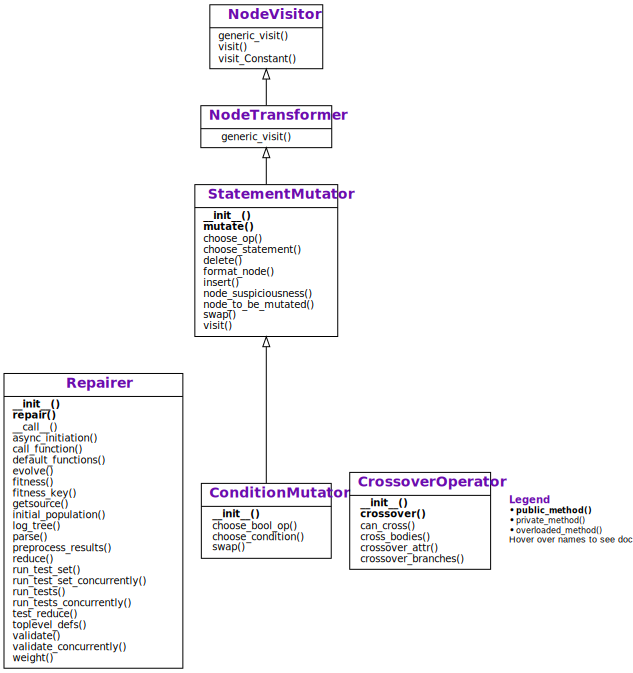

In [197]:
# ignore
display_class_hierarchy([Repairer, ConditionMutator, CrossoverOperator],
                        public_methods=[
                            Repairer.__init__,
                            Repairer.repair,
                            StatementMutator.__init__,
                            StatementMutator.mutate,
                            ConditionMutator.__init__,
                            CrossoverOperator.__init__,
                            CrossoverOperator.crossover,
                        ],
                        project='debuggingbook')

## Lessons Learned

* Automated repair based on genetic optimization uses five ingredients:
    1. A _test suite_ to determine passing and failing tests
    2. _Defect localization_ (typically obtained from [statistical debugging](StatisticalDebugger.ipynb) with the test suite) to determine potential locations to be fixed
    3. _Random code mutations_ and _crossover operations_ to create and evolve a population of inputs
    4. A _fitness function_ and a _selection strategy_ to determine the part of the population that should be evolved further
    5. A _reducer_ such as [delta debugging](DeltaDebugger.ipynb) to simplify the final candidate with the highest fitness.
* The result of automated repair is a _fix candidate_ with the highest fitness for the given tests.
* A _fix candidate_ is not guaranteed to be correct or optimal, but gives important hints on how to fix the program.
* All of the above ingredients offer plenty of settings and alternatives to experiment with.

## Background

The seminal work in automated repair is [GenProg](https://squareslab.github.io/genprog-code/) \cite{LeGoues2012}, which heavily inspired our `Repairer` implementation. Major differences between GenProg and `Repairer` include:

* GenProg includes its own defect localization (which is also dynamically updated), whereas `Repairer` builds on earlier statistical debugging.
* GenProg can apply multiple mutations on programs (or none at all), whereas `Repairer` applies exactly one mutation.
* The `StatementMutator` used by `Repairer` includes various special cases for program structures (`if`, `for`, `while`...), whereas GenProg operates on statements only.
* GenProg has been tested on large production programs.

While GenProg is _the_ seminal work in the area (and arguably the most important software engineering research contribution of the 2010s), there have been a number of important extensions of automated repair. These include:

* *AutoFix* \cite{Pei2014} leverages _program contracts_ (pre- and postconditions) to generate tests and assertions automatically. Not only do such [assertions](Assertions.ipynb) help in fault localization, they also allow for much better validation of fix candidates.
* *SemFix* \cite{Nguyen2013} presents automated program repair based on _symbolic analysis_ rather than genetic optimization. This allows to leverage program semantics, which GenProg does not consider.

To learn more about automated program repair, see [program-repair.org](http://program-repair.org), the community page dedicated to research in program repair.

## Exercises

### Exercise 1: Automated Repair Parameters

Automated Repair is influenced by a large number of design choices – the size of the population, the number of iterations, the genetic optimization strategy, and more. How do changes to these design choices affect its effectiveness? 

* Consider the constants defined in this chapter (such as `POPULATION_SIZE` or `WEIGHT_PASSING` vs. `WEIGHT_FAILING`). How do changes affect the effectiveness of automated repair?
* As an effectiveness metric, consider the number of iterations it takes to produce a fix candidate.
* Since genetic optimization is a random algorithm, you need to determine effectiveness averages over a large number of runs (say, 100).

### Answer 1:
Changing `WEIGHT_PASSING` and `WEIGHT_FAILING` results in longer runtime, already good values. Lowering `POPULATION_SIZE` causes the algorithm to terminate faster

### Exercise 2: Elitism

[_Elitism_](https://en.wikipedia.org/wiki/Genetic_algorithm#Elitism) (also known as _elitist selection_) is a variant of genetic selection in which a small fraction of the fittest candidates of the last population are included unchanged in the offspring.

* Implement elitist selection by subclassing the `evolve()` method. Experiment with various fractions (5%, 10%, 25%) of "elites" and see how this improves results.


In [198]:
class Repairer(Repairer):
    def evolve(self, population):
        """Evolve the candidate population by mutating and crossover, in this case including an elitist selection."""
        n = len(population)
        possible_fractions = [0.05,0.10,0.20]
        elite = int(n * (1-possible_fractions[2]))   #TODO: mit Werten spielen yo
        
        # Create offspring as crossover of parents
        offspring = []
        while len(offspring) < n:
            parent_1 = copy.deepcopy(random.choice(population))
            parent_2 = copy.deepcopy(random.choice(population))
            try:
                self.crossover.crossover(parent_1, parent_2)
            except CrossoverError:
                pass  # Just keep parents
            offspring += [parent_1, parent_2]

        # Mutate offspring
        offspring = [self.mutator.mutate(tree) for tree in offspring]

        # Add it to population
        population += offspring

        # Keep the elite part of the population
        population.sort(key=self.fitness_key, reverse=True)
        elite = max(15,elite)
        population = population[:n] 

        return population

### Exercise 3: Evolving Values

Following the steps of `ConditionMutator`, implement a `ValueMutator` class that replaces one constant value by another one found in the source (say, `0` by `1` or `True` by `False`).

For validation, consider the following failure in the `square_root()` function from [the chapter on assertions](Assertions.ipynb):

In [199]:
from Assertions import square_root  # minor dependency

In [200]:
def square_root(x):
    assert x >= 0  # precondition

    approx = None
    guess = x / 2
    while approx != guess:
        approx = guess
        guess = (approx + x / approx) / 2

    assert math.isclose(approx * approx, x)
    return approx

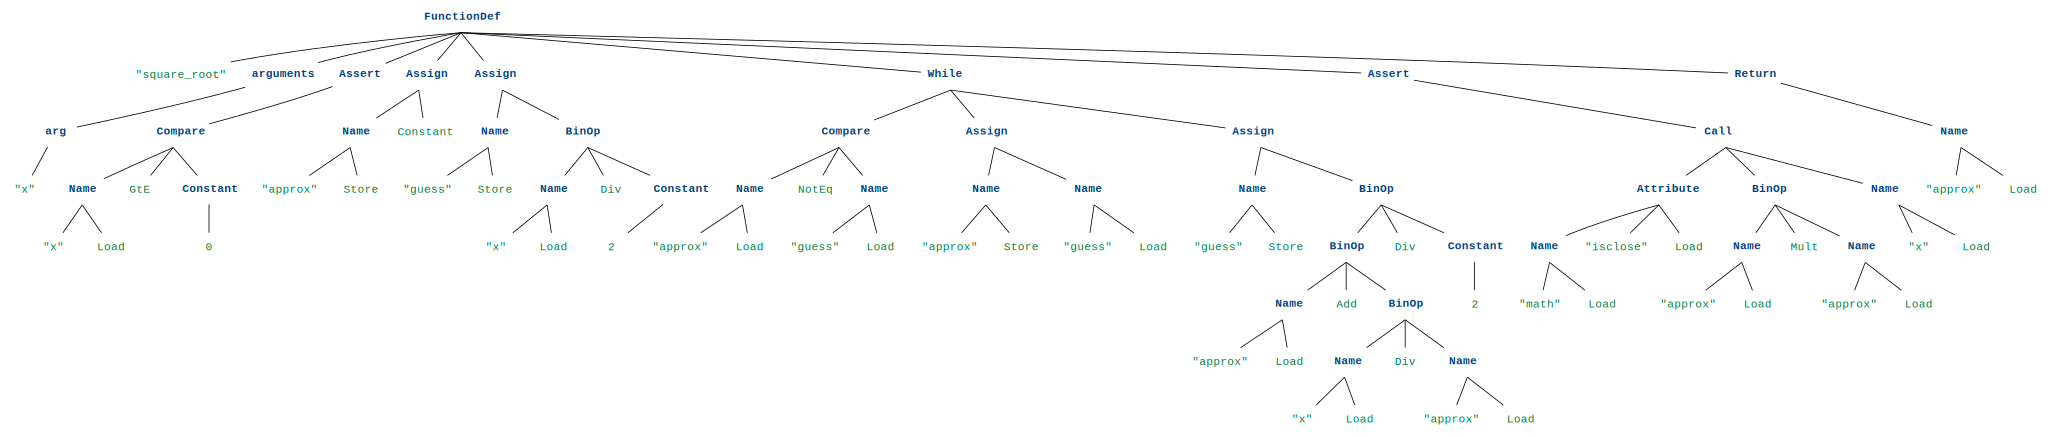

In [201]:
unfixed_square_root_tree = ast.parse(inspect.getsource(square_root))
show_ast(unfixed_square_root_tree)

In [202]:
with ExpectError():
    square_root_of_zero = square_root(0)

Traceback (most recent call last):
  File "<ipython-input-202-751aff5e3a1c>", line 2, in <module>
    square_root_of_zero = square_root(0)
  File "<ipython-input-200-9c2f33817d60>", line 8, in square_root
    guess = (approx + x / approx) / 2
ZeroDivisionError: float division by zero (expected)


Can your `ValueMutator` automatically fix this failure?

**Solution.** Your solution will be effective if it also includes named constants such as `None`.

In [203]:
import math

In [204]:
def square_root_fixed(x):
    assert x >= 0  # precondition
    
    test = True
    approx = 0  # <-- FIX: Change `None` to 0
    guess = x / 2
    while approx != guess:
        approx = guess
        guess = (approx + x / approx) / 2

    assert math.isclose(approx * approx, x)
    return approx

In [205]:
square_root_fixed(0)

0

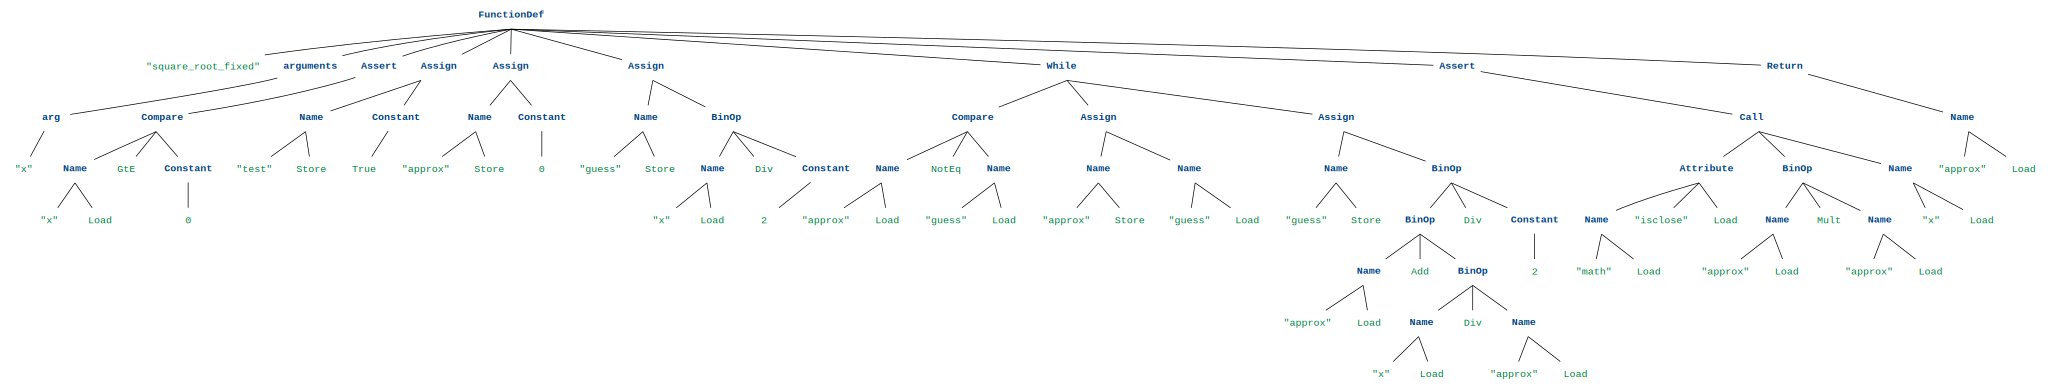

In [206]:
square_root_tree = ast.parse(inspect.getsource(square_root_fixed))
show_ast(square_root_tree)

### Answer 3: `ValueMutator`

In [207]:
class ConstValueVisitor(NodeVisitor):
    def __init__(self):
        self.const_values = []
        self.const_values_seen = set()
        super().__init__()
    
    def add_const_value(self,node):
#        print(f" Visited const value {node.value}")
        self.const_values.append(node)
        self.const_values_seen.add(node.value)
        
    def visit_Constant(self,node):
        self.add_const_value(node)
        return super().generic_visit(node)
    
    def generic_visit(self, node):
        return super().generic_visit(node)

In [208]:
def all_const_values(trees, tp = None):
    """Return all constant values from the AST (or AST list) `trees`.
    If `tp` is given, return only elements of that type."""
    if not isinstance(trees, list):
        assert isinstance(trees, ast.AST)
        trees = [trees]
    
    visitor = ConstValueVisitor()
    
    for tree in trees:
        visitor.visit(tree)
    
    const_nodes = visitor.const_values
    seen_values = visitor.const_values_seen
    return const_nodes, seen_values

In [209]:
all_const_values(unfixed_square_root_tree)

([<_ast.Constant at 0x7fcd5b76d850>,
 {0, 2, None})

In [210]:
class ValueMutator(StatementMutator):
    """Mutate constant values in an AST"""

    def __init__(self, *args, **kwargs):
        """Constructor. Arguments are as with `StatementMutator` constructor."""
        super().__init__(*args, **kwargs)
        self.const_nodes, self.seen_values = all_const_values(self.source)  #TODO: Find all statements containing constant values yo 
        if self.log:
            print("Found constant values: ",
                  [node.value for node in self.const_nodes])
    
    def choose_const_node(self):
        """Return a random constant node from source."""
        return random.choice(self.const_nodes)
    
    def mutatable_subnode(self,tree):
        visitor = ConstValueVisitor()
        visitor.visit(tree)
        if(len(visitor.const_values)>0):
            return random.choice(visitor.const_values)
        else:
            return None
    
    def node_to_be_mutated(self,tree):
        const_values = all_const_values(tree)[0]
        return random.choice(const_values)
        
    def find_replacement_value(self,node):
        """Return a replacing constant value from source for a given node"""
        for const_node in self.const_nodes:
            if(const_node.value != node.value):
                return const_node.value
        
        return None
    
    def swap_values(self, node): 
        mutated_subnode = self.mutatable_subnode(node)
        if mutated_subnode is None:
            return super().swap(node)
        else:
            old_value = mutated_subnode.value
            replacing_value = self.find_replacement_value(mutated_subnode)
            mutated_subnode.value = replacing_value
            return node

    def visit(self, node):
        super(NodeTransformer, self).visit(node)  # Visits (and transforms?) children
        if not node.mutate_me:
            return node
        else:
            new_node = self.swap_values(node)
            return new_node
            
    def mutate(self, tree):
        """Mutate the given AST `tree` in place 
        The only considered mutations are value mutations. Return mutated tree."""
        
        new_tree = copy.deepcopy(tree)     #TODO: Umnennen
        node_to_be_mutated = self.node_to_be_mutated(new_tree)
        
        for node in ast.walk(new_tree):
            node.mutate_me = False
            
        node_to_be_mutated.mutate_me = True
        
        new_tree = self.visit(new_tree)
        ast.fix_missing_locations(new_tree)
        
        return new_tree
        

In [211]:
value_mutator = ValueMutator(source = all_statements(unfixed_square_root_tree), log = True)
print(f"Random pick from const values: {value_mutator.choose_const_node().value}")

Found constant values:  [0, None, 2, 2, 2]
Random pick from const values: 0


In [212]:
def compile_and_test(tree):
    try:
        code = compile(tree, '<code>', 'exec')
        result = exec(code,globals())
        if square_root(0) == 0:
            return True
        return False
    except Exception as e:
        return False
    

In [213]:
test_tree = value_mutator.mutate(unfixed_square_root_tree)

while(compile_and_test(test_tree)==False):
    test_tree = value_mutator.mutate(unfixed_square_root_tree)

print_content(astor.to_source(test_tree),'.py')
print(f"\nResult of square root of zero: {square_root(0)}")

def square_root(x):
    assert x >= 0
    approx = 0
    guess = x / 2
    while approx != guess:
        approx = guess
        guess = (approx + x / approx) / 2
    assert math.isclose(approx * approx, x)
    return approx
Result of square root of zero: 0


### Exercise 4: Evolving Variable Names

Following the steps of `ConditionMutator`, implement a `IdentifierMutator` class that replaces one identifier by another one found in the source (say, `y` by `x`). Does it help fixing the `middle()` error?

### Answer 4:
Implementation of `IdentifierMutator` and `IdentifierVisitor`:


In [214]:
class IdentifierVisitor(NodeVisitor):
    def __init__(self):
        self.identifiers = []
        self.identifiers_seen = set()
        super().__init__()
    
    def add_identifier(self,node):
        self.identifiers.append(node)
        self.identifiers_seen.add(node.id)

    def visit_Name(self,node):
        self.add_identifier(node)
        return super().generic_visit(node)
        
    def generic_visit(self,node):
        return super().generic_visit(node)

In [215]:
def all_identifiers(trees, tp = None):
    """Return all identifiers from the AST (or AST list) `trees`.
    If `tp` is given, return only elements of that type."""

    if not isinstance(trees, list):
        assert isinstance(trees, ast.AST)
        trees = [trees]
    
    id_visitor = IdentifierVisitor()
    for tree in trees:
        id_visitor.visit(tree)
        
    return id_visitor.identifiers

def seen_ids(tree):
    id_visitor = IdentifierVisitor()
    id_visitor.visit(tree)
    return id_visitor.identifiers_seen

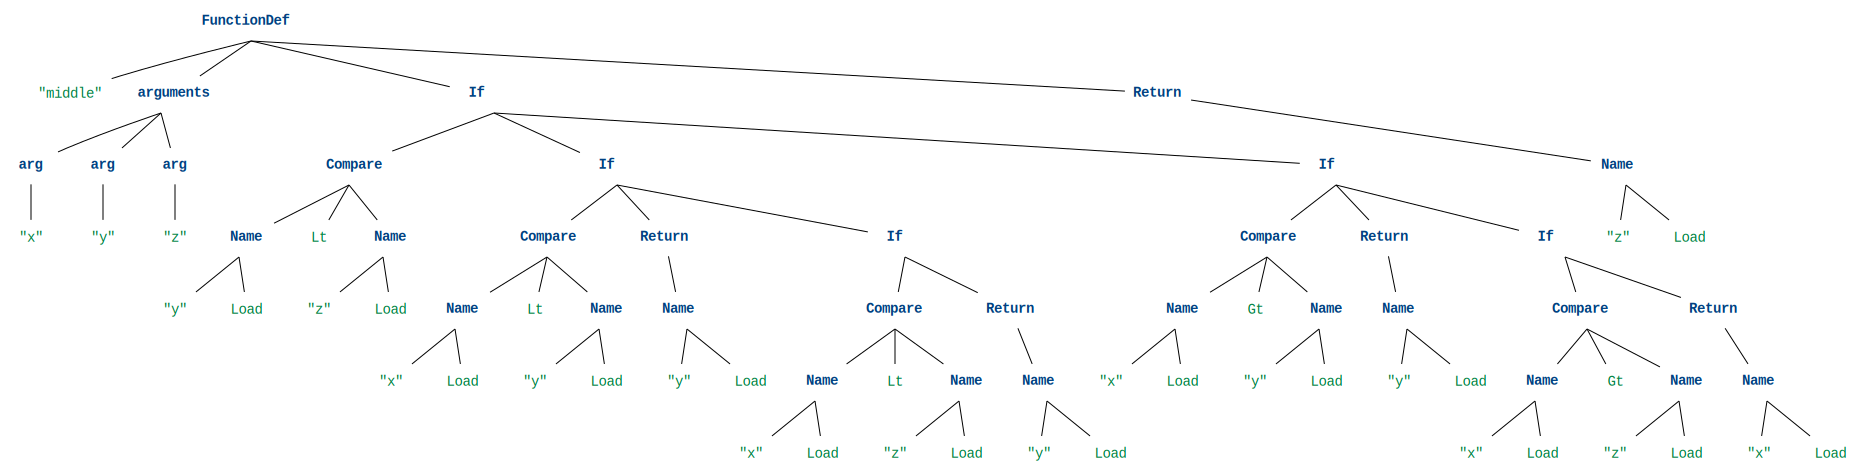

In [216]:
middle_code = inspect.getsource(middle)
middle_tree = ast.parse(middle_code)
show_ast(middle_tree)

In [217]:
all_identifiers(middle_tree)
seen_ids(middle_tree)

{'x', 'y', 'z'}

In [218]:
class IdentifierMutator(StatementMutator):
    """Mutate identifiers in an AST"""
    
    def __init__(self, *args, **kwargs):
        """Constructor. Arguments are as with `StatementMutator` constructor."""
        super().__init__(*args, **kwargs)
        self.identifiers = all_identifiers(self.source)
        if self.log:
            print("Found statements containing the following identifiers: ",
                  [astor.to_source(id).strip() 
                   for id in self.identifiers])
            
    def node_to_be_mutated(self,tree):
        id_visitor = IdentifierVisitor()
        id_visitor.visit(tree)
        return random.choice(id_visitor.identifiers)
    
    def mutatable_subnode(self, tree):
        id_visitor = IdentifierVisitor()
        id_visitor.visit(tree)
        if (len(id_visitor.identifiers) > 0):
            return random.choice(id_visitor.identifiers)
        else:
            return None
    
    def get_replacing_id(self,node):
        current_id = node.id
        random_id = random.choice(self.identifiers).id
        if(len(self.identifiers) == 1):
            return current_id
        else:
            while(str(current_id) == str(random_id)):
                random_id = random.choice(self.identifiers).id
            return random_id
        
    def swap_ids(self, node):
        mutate_node = self.mutatable_subnode(node)
        if mutate_node is None:
            print("There is no mutatable subnode")
            return super().swap(node)
        else:
            old_id = mutate_node.id
            replacing_id = self.get_replacing_id(mutate_node)
            mutate_node.id = replacing_id
            return node

    def visit(self, node):
        super(NodeTransformer, self).visit(node)
        if not node.mutate_me:
            return node
        else:
            new_node = self.swap_ids(node)
            return new_node
            
    def mutate(self, tree):
        """Mutate the given AST `tree` in place 
        The only considered mutations are id mutations. Return mutated tree."""
        
        #TODO: eventuell hier oben self.identifers, seen_identifiers ändern
        new_tree = copy.deepcopy(tree)    
        
        for node in ast.walk(new_tree):
            node.mutate_me = False
            
        node_to_be_mutated = self.node_to_be_mutated(new_tree)
        node_to_be_mutated.mutate_me = True
        
        new_tree = self.visit(new_tree)
        
        ast.fix_missing_locations(new_tree)
        return new_tree
        

In [219]:
middle_tree = ast.parse(inspect.getsource(middle))
id_mutator = IdentifierMutator(source = middle_tree,log=True)
print_content(astor.to_source(middle_tree),'.py')

Found statements containing the following identifiers:  ['y', 'z', 'x', 'y', 'y', 'x', 'z', 'y', 'x', 'y', 'y', 'x', 'z', 'x', 'z']
def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return y
    elif x > y:
        return y
    elif x > z:
        return x
    return z

In [220]:
new_tree = id_mutator.mutate(middle_tree)
print_content(astor.to_source(new_tree),'.py')

while(middle_fitness(new_tree) < 1):
    new_tree = id_mutator.mutate(middle_tree)

code = compile(tree, '<code>', 'exec')
exec(code, globals())

print_content(astor.to_source(new_tree),'.py')
middle(2,1,3)

def middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return y
    elif x > y:
        return y
    elif x > y:
        return x
    return zdef middle(x, y, z):
    if y < z:
        if x < y:
            return y
        elif x < z:
            return x
    elif x > y:
        return y
    elif x > z:
        return x
    return z

2

### Exercise 5: Parallel Repair

Automatic Repair is a technique that is embarrassingly parallel – all tests for one candidate can all be run in parallel, and all tests for _all_ candidates can also be run in parallel. Set up an infrastructure for running concurrent tests using Pythons [asyncio](https://docs.python.org/3/library/asyncio.html) library.

In [221]:
### multiprocessing-Pool Example Sleepsort with preprocessing of available data###
q = Queue()

def async_wait(i):
    global q
    time.sleep(i*1.5)
    print(f"{i} handed over for preprocessing")
    q.put(i)
    return i

def preprocessing_worker():
    global q
    print("Big Preprocessor is watching you")
    counter = 0
    while(counter<9):
        item = q.get()
        print(f"Preprocessing item: {item}")
        counter += 1
        
"""
randomlist = random.sample(range(1, 10), 9)
print(f"Unsorted List: {randomlist}")

preprocessor = Process(target=preprocessing_worker,args = ())
preprocessor.start()
with Pool() as p:
    global q
    p.map(async_wait, randomlist)
    preprocessor.join()
    print("Finished sorting and preprocessing the unsorted list")
"""

'\nrandomlist = random.sample(range(1, 10), 9)\nprint(f"Unsorted List: {randomlist}")\n\npreprocessor = Process(target=preprocessing_worker,args = ())\npreprocessor.start()\nwith Pool() as p:\n    global q\n    p.map(async_wait, randomlist)\n    preprocessor.join()\n    print("Finished sorting and preprocessing the unsorted list")\n'

### Loop Mutator
The following class mutates the ranges of loops, i.e. `range(1,n)` => `range(1,n+1)` or `range(1,n)` => `range(1,n-1)`

In [222]:
class LoopVisitor(NodeVisitor):
    def __init__(self):
        self.loops = []
        super().__init__()
    
    def add_loop(self,node):
        self.loops.append(node)

    def visit_For(self,node):
        self.add_loop(node)
        return super().generic_visit(node)
    
    def visit_While(self,node):
        self.add_loop(node)
        return super().generic_visit(node)
        
    def generic_visit(self,node):
        return super().generic_visit(node)

In [223]:
def all_loops(trees, tp = None):
    """Return all identifiers from the AST (or AST list) `trees`.
    If `tp` is given, return only elements of that type."""
    if not isinstance(trees, list):
        assert isinstance(trees, ast.AST)
        trees = [trees]
    
    loop_visitor = LoopVisitor()
    for tree in trees:
        loop_visitor.visit(tree)
        
    return loop_visitor.loops

In [224]:
class LoopMutator(StatementMutator):
    """Mutate Loops in an AST"""
    def __init__(self, *args, **kwargs):
        """Constructor. Arguments are as with `StatementMutator` constructor."""
        super().__init__(*args, **kwargs)
        self.loops = all_loops(self.source)
        self.num_replaced_ids = 0
        if self.log:
            print("Found the following Loops in Source: ",
                  [astor.to_source(loop).strip() 
                   for loop in self.loops])
            
    def loop_to_be_mutated(self,tree):
        loop_visitor = LoopVisitor()
        loop_visitor.visit(tree)
        chosen_loop = random.choice(loop_visitor.loops)
    
    def new_range(self,node):
        current_iter = node.iter
        random_iter = random.choice(self.loops).iter
        if(len(self.loops) == 1):
            return current_iter == random_iter
        else:
            while(current_iter == random_iter):
                random_iter = random.choice(self.loops).iter
            return random_iter
        
    def mutate_range(self, node):
        has_target = hasattr(node, 'target')
        has_iter = hasattr(node, 'iter')
        if (has_target and has_iter):
            target_var_id = node.target.id
            new_var_id = "replacement_id" + str(self.num_replaced_ids)
            self.num_replaced_ids += 1
            node.target.id = new_var_id
            for assignment in all_assignments(node)[0]:
                for var in all_identifiers(assignment.value):
                     if var.id == target_var_id:
                        var.id = new_var_id
        return node   
        
    def swap_range(self, node):
        if not hasattr(node, 'iter'):
            return super().swap(node)
        else:
            old_iter = node.iter
            replacing_iter = self.mutate_range(node)
            node.iter = replacing_iter
            return node
    
    def visit(self, node):
        super(NodeTransformer, self).visit(node)
        if not node.mutate_me:
            return node
        else:
            new_node = self.swap_range(node)
            return new_node
            
    def mutate(self, tree):
        """Mutate the given AST `tree` in place 
        The only considered mutations are id mutations. Return mutated tree."""
        
        #TODO: eventuell hier oben self.identifers, seen_identifiers ändern
        new_tree = copy.deepcopy(tree)    
        
        for node in ast.walk(new_tree):
            node.mutate_me = False
            
        node_to_be_mutated = self.loop_to_be_mutated(new_tree)
        node_to_be_mutated.mutate_me = True
        
        new_tree = self.visit(new_tree)
        
        ast.fix_missing_locations(new_tree)
        return new_tree
        

### AssignmentMutator
The following class mutates Assignments by adding, subtracting or multiplying constants or variables from source

In [225]:
class AssignVisitor(NodeVisitor):
    def __init__(self):
        self.assigns = []
        self.seen_assigns = set()
        super().__init__()
    
    def add_assignment(self,node):
        self.assigns.append(node)
        self.seen_assigns.add(node)
        
    def visit_Assign(self,node):
        self.add_assignment(node)
        return super().generic_visit(node)
    
    def visit_AugAssign(self,node):
        self.add_assignment(node)
        return super().generic_visit(node)
        
    def generic_visit(self,node):
        return super().generic_visit(node)

In [226]:
class AssignMutator(StatementMutator):
    """Mutate Loops in an AST"""
    def __init__(self, *args, **kwargs):
        """Constructor. Arguments are as with `StatementMutator` constructor."""
        super().__init__(*args, **kwargs)
        self.assignments, self.seen_assignments = all_assignments(self.source)
        self.const_values, self.seen_values = all_const_values(self.source)
        self.identifiers = all_identifiers(self.source)

        if self.log:
            print("Found statements containing the following assignments: ",
                  [astor.to_source(assign).strip() 
                   for assign in self.assignments])
            
    def assignment_to_be_mutated(self,tree):
        assign_visitor = AssignVisitor()
        assign_visitor.visit(tree)
        return random.choice(assign_visitor.assigns)
    
    def choose_mutator_op(self):
        choice =  random.choice(["add"])
        if choice == "add":
            return ast.Add()
    
    def mutate_assignment(self, node):
        replacing_op = self.choose_mutator_op()
        
        if(len(self.seen_values)>0):
            replacing_const = ast.Constant(random.choice(tuple(self.seen_values)))
        elif(len(self.identifiers)>0):
            replacing_const = random.choice(self.identifiers)
        else:
            replacing_const = ast.Constant(1)
            
        if hasattr(node, 'op') or hasattr(node, 'value'):
            current_assign_value = node.value
            replacing_assignment = ast.BinOp(left=current_assign_value, op = replacing_op, right=replacing_const)
            node.value = replacing_assignment
            return node
        else:
            return super().insert(node)
                   
    def visit(self, node):
        super(NodeTransformer, self).visit(node)
        if not node.mutate_me:
            return node
        else:
            new_node = self.mutate_assignment(node)
            return new_node
            
    def mutate(self, tree):
        """Mutate the given AST `tree` in place 
        The only considered mutations are id mutations. Return mutated tree."""
        
        #TODO: eventuell hier oben self.identifers, seen_identifiers ändern
        new_tree = copy.deepcopy(tree)    
        
        for node in ast.walk(new_tree):
            node.mutate_me = False
            
        assignment_to_be_mutated = self.assignment_to_be_mutated(new_tree)
        assignment_to_be_mutated.mutate_me = True
        
        new_tree = self.visit(new_tree)
        
        ast.fix_missing_locations(new_tree)
        return new_tree
        

In [227]:
def all_assignments(trees, tp = None):
    """Return all identifiers from the AST (or AST list) `trees`.
    If `tp` is given, return only elements of that type."""
    if not isinstance(trees, list):
        assert isinstance(trees, ast.AST)
        trees = [trees]
    
    assign_visitor = AssignVisitor()
    for tree in trees:
        assign_visitor.visit(tree)
        
    return (assign_visitor.assigns,assign_visitor.seen_assigns)

### OperatorMutator
The `OperatorMutator` class mutates the operators in assignments, e.g. `x = a + b` => `x = a * b` ; `x += b` => `x *= b`

In [228]:
class OperatorVisitor(NodeVisitor):
    def __init__(self):
        self.operators = []
        self.seen_ops = set()
        super().__init__()
    
    def add_operator(self,node):
        print(f"Found operator: {node}")
        self.operators.append(node)
        self.seen_ops.add(node.op)
        
    def visit_BinOp(self,node):
        self.add_operator(node)
        return super().generic_visit(node)
    
    def visit_UnaryOp(self, node):
        self.add_operator(node)
        return super().generic_visit(node)
    
    def visit_BoolOp(self, node):
        self.add_operator(node)
        return super().generic_visit(node)
    
    def visit_AugAssign(self,node):
        self.add_operator(node)
        return super().generic_visit(node)
        
    def generic_visit(self,node):
        return super().generic_visit(node) 

In [229]:
def all_operators(trees, tp = None):
    """Return all identifiers from the AST (or AST list) `trees`.
    If `tp` is given, return only elements of that type."""

    if not isinstance(trees, list):
        assert isinstance(trees, ast.AST)
        trees = [trees]
    
    op_visitor = OperatorVisitor()
    for tree in trees:
        op_visitor.visit(tree)
        
    return op_visitor.operators

In [230]:
class OperatorMutator(StatementMutator):
    """Mutate Loops in an AST"""
    def __init__(self, *args, **kwargs):
        """Constructor. Arguments are as with `StatementMutator` constructor."""
        super().__init__(*args, **kwargs)
        self.operators = all_operators(self.source)

        if self.log:
            print("Found statements containing the following assignments: ",
                  [astor.to_source(op).strip() 
                   for op in self.operators])
            
    def operator_to_be_mutated(self,tree):
        op_visitor = OperatorVisitor()
        op_visitor.visit(tree)
        if(len(op_visitor.operators)>0):
            return random.choice(op_visitor.operators)
        else:
            return None
   
    def choose_mutated_op(self, current_op):
        choices = [ast.Add,ast.Mult]
        choice = random.choice(choices)
        while(isinstance(current_op, choice)):
            choice = random.choice(choices)
        
        return choice()  
    
    def mutate_operator(self, node):
        if hasattr(node, 'op'):
            replacing_op = self.choose_mutated_op(node.op)
            node.op = replacing_op
        return node
                   
    def visit(self, node):
        super(NodeTransformer, self).visit(node)
        if not node.mutate_me:
            return node
        else:
            new_node = self.mutate_operator(node)
            return new_node
            
    def mutate(self, tree):
        """Mutate the given AST `tree` in place 
        The only considered mutations are id mutations. Return mutated tree."""
        
        #TODO: eventuell hier oben self.identifers, seen_identifiers ändern
        new_tree = copy.deepcopy(tree)    
        
        for node in ast.walk(new_tree):
            node.mutate_me = False
            
        assignment_to_be_mutated = self.assignment_to_be_mutated(new_tree)
        assignment_to_be_mutated.mutate_me = True
        
        new_tree = self.visit(new_tree)
        
        ast.fix_missing_locations(new_tree)
        return new_tree
        

### Test-Function Runner
The following class facilitates the detection of endless loops, and terminates the execution of functions that take a suspiciously long amount of time to execute

In [231]:
def run_function(args_list, function,feedback_queue):
    for args in args_list:
        try:
            function(**args)
            feedback_queue.put("SUCCESS")
        except Exception as e:
            feedback_queue.put("FAILURE")
        
def function_runner_process(function, args_list):
    feedback_communicator = Queue()
    procs = []
    
    fun_runner = Process(target=run_function, args = (args_list, function, feedback_communicator))
    procs.append(fun_runner)
    fun_runner.start()
    
    TIMEOUT = 1.5
    start = time.time()
    
    while time.time() - start <= TIMEOUT:
        if not any(p.is_alive() for p in procs):
            break #In this case, our function runner has terminated the exectuion of all fun calls
        time.sleep(.05)  
    else:
        # Handle timeout, indicating endless loop
        print(f"At least one process did not terminate before timeout of {TIMEOUT} seconds")
        for p in procs:
            p.terminate()
            p.join()
    
    num_passed = 0
    
    while(not feedback_communicator.empty()):
        feedback = feedback_communicator.get()
        if (feedback == "SUCCESS"):
            num_passed += 1
    return num_passed
            

In [232]:
class Repairer(Repairer):
    def run_test_set(self, test_set, validate=False):
        """Run given `test_set`
        (`DifferenceDebugger.PASS` or `DifferenceDebugger.FAIL`).
        If `validate` is set, check expectations.
        Return number of passed tests."""
        passed = 0
        collectors = self.debugger.collectors[test_set]     
        function = self.debugger.function()
        # FIXME: function may have been redefined
        
        args_to_test = list()
        
        for c in collectors:
            if self.log >= 4:
                print(f"Testing {c.id()}...", end="")
            args_to_test.append(c.args())
            
        num_passed = function_runner_process(function, args_to_test)
        
        return num_passed

### Meta Mutator
The following class is a combination of the Mutator classes defined above, considering Mutations of each class (`ConditionMutator`, `IdentifierMutator`, `ValueMutator`, `RangeMutator`). This can then be used as the Mutator class of our `Repairer` to allow the fixing of multiple problems.

In [233]:
class MetaMutator(StatementMutator):
    def __init__(self, *args, **kwargs):
        """Constructor. Arguments are as with `StatementMutator` constructor."""
        super().__init__(*args, **kwargs)
        self.value_mutator = ValueMutator(source = self.source, log = True)
        self.condition_mutator = ConditionMutator(source = self.source, log = True)
        self.identifier_mutator = IdentifierMutator(source = self.source, log = True)
        self.assignment_mutator = AssignMutator(source = self.source, log = True)
        self.loop_mutator = LoopMutator(source = self.source, log = True)
        self.op_mutator = OperatorMutator(source = self.source, log = True)
    
    def check_applicability(self, choice, node):
        if choice == "identifier_mutator":
            return self.identifier_mutator.mutatable_subnode(node) is not None
        elif choice == "value_mutator":
            return self.value_mutator.mutatable_subnode(node) is not None
        elif choice == "assignment_mutator":
            return ((hasattr(node, 'op') or hasattr(node, 'value'))) and (len(self.assignment_mutator.seen_values)>0 or len(self.assignment_mutator.identifiers)>0)
        elif choice == "loop_mutator":
            return hasattr(node, 'target') and hasattr(node, 'iter')
        elif choice == "op_mutator":
            return hasattr(node, 'op')
        elif choice == "condition_mutator":
            return hasattr(node, 'test')
        return True
    
    def equal_chance_operator_selector(self, node):
        chosen_operator = None
        choices = ["insert", "op_mutator", "loop_mutator", "assignment_mutator", "condition_mutator", "identifier_mutator", "value_mutator", "default_swap", "delete"]
        choice = random.choice(choices)
        
        while(not self.check_applicability(choice, node)):
            choice = random.choice(choices)

        if(choice == "condition_mutator"):
            chosen_operator = self.condition_mutator.swap
        elif(choice == "identifier_mutator"):
            chosen_operator = self.identifier_mutator.swap_ids
        elif(choice == "value_mutator"):
            chosen_operator = self.value_mutator.swap_values
        elif(choice == "default_swap"):
            if self.check_applicability("condition_mutator", node):
                chosen_operator = self.condition_mutator.swap
            else:
                chosen_operator = super().swap
        elif(choice =="assignment_mutator"):
            chosen_operator = self.assignment_mutator.mutate_assignment
        elif(choice == "insert"):
            chosen_operator = super().insert
        elif(choice == "loop_mutator"):
            chosen_operator = self.loop_mutator.mutate_range
        elif(choice == "op_mutator"):
            chosen_operator = self.op_mutator.mutate_operator
        else:
            chosen_operator = super().delete
                
        return chosen_operator
    
    def visit(self, node):
        super(NodeTransformer, self).visit(node)
        if not node.mutate_me:
            return node
        old_node = copy.deepcopy(node)
        op = self.equal_chance_operator_selector(node)
        new_node = op(node)
        self.mutations += 1

        if self.log:
            print(f"{node.lineno:4}:{op.__name__ + ':':7} "
                  f"{self.format_node(old_node)} "
                  f"becomes {self.format_node(new_node)}")

        return new_node
    
    def mutate(self, tree):
        """Mutate the given AST `tree` in place. Return mutated tree."""
        assert isinstance(tree, ast.AST)

        new_tree = copy.deepcopy(tree)

        if not self.source:
            self.source = all_statements(new_tree)

        for node in ast.walk(new_tree):
            node.mutate_me = False

        node = self.node_to_be_mutated(new_tree)
        node.mutate_me = True

        self.mutations = 0

        new_tree = self.visit(new_tree)

        if self.mutations == 0:
            warnings.warn("No mutations found")

        ast.fix_missing_locations(new_tree)
        return new_tree

In [234]:
from StatisticalDebugger import middle

In [235]:
middle_tree = ast.parse(inspect.getsource(middle))
meta_mutator = MetaMutator(source = all_statements(middle_tree),log=True)

Found constant values:  []
Found conditions ['(y < z)', '(x < y)', '(x < z)', '(x > y)', '(x > z)']
Found statements containing the following identifiers:  ['y', 'z', 'x', 'y', 'y', 'x', 'z', 'y', 'x', 'y', 'y', 'x', 'z', 'x', 'z', 'x', 'y', 'y', 'x', 'z', 'y', 'x', 'y', 'y', 'x', 'z', 'x', 'y', 'x', 'z', 'y', 'y', 'y', 'x', 'z', 'x', 'x']
Found statements containing the following assignments:  []
Found the following Loops in Source:  []
Found statements containing the following assignments:  []


In [236]:
new_tree = meta_mutator.mutate(middle_tree)

while(middle_fitness(new_tree) < 1):
    new_tree = meta_mutator.mutate(middle_tree)

code = compile(new_tree, '<code>', 'exec')
exec(code, globals())

print_content(astor.to_source(new_tree),'.py')
middle(2,1,3)

  10:swap:   'if x > z: return x' becomes 'if x < z or x > z: return x'
   4:insert: 'return y' becomes 'return y'
  11:swap:   'return x' becomes 'return y'
   4:delete: 'return y' becomes 'pass'
  11:mutate_assignment: 'return x' becomes 'return x + z'
   3:swap:   'if x < y: return y elif x < z: return y...' becomes 'if x > z: return y elif x < z: return y...'
  12:swap:   'return z' becomes 'if x > y: pass'
   4:swap:   'return y' becomes 'return y'
   8:swap_ids: 'if x > y: return y elif x > z: return x...' becomes 'if x > y: return y elif y > z: return x...'
   6:delete: 'return y' becomes 'pass'
  12:insert: 'return z' becomes 'if x < y: return z'
  11:delete: 'return x' becomes 'pass'
   3:swap:   'if x < y: return y elif x < z: return y...' becomes 'if y < z or x < y: return y elif x < z: ...'
   3:insert: 'if x < y: return y elif x < z: return y...' becomes 'if y < z: if x < y: return y elif x < z:...'
  11:delete: 'return x' becomes 'pass'
  10:insert: 'if x > z: return x' b

2

In [237]:
html_debugger = OchiaiDebugger()
for html, plain in (REMOVE_HTML_PASSING_TESTCASES + 
                    REMOVE_HTML_FAILING_TESTCASES):
    with html_debugger:
        remove_html_markup_test(html, plain)
html_debugger

1  70% def remove_html_markup_test(html, plain):
   2  70%     outcome = remove_html_markup(html)
   3  70%     assert outcome == plain, \
   4 100%         f"Got {repr(outcome)}, expected {repr(plain)}"

   1  70% def remove_html_markup(s):
   2  70%     tag = False
   3  70%     quote = False
   4  70%     out = ""
   5
   6  70%     for c in s:
   7  70%         if c == '<' and not quote:
   8  55%             tag = True
   9  70%         elif c == '>' and not quote:
  10  57%             tag = False
  11  70%         elif c == '"' or c == "'" and tag:
  12  70%             quote = not quote
  13  70%         elif not tag:
  14  70%             out = out + c
  15
  16  70%     return out

Target code to be repaired:
def remove_html_markup(s):
    tag = False
    quote = False
    out = ''
    for c in s:
        if c == '<' and not quote:
            tag = True
        elif c == '>' and not quote:
            tag = False
        elif c == '"' or c == "'" and tag:
            quote = not quote
        elif not tag:
            out = out + c
    return out

Found constant values:  [False, False, '', '<', True, '>', False, '"', "'", '<', True, '>', False, '"', "'", True, '>', False, '"', "'", False, '"', "'"]
Found conditions ["(c == '<' and not quote)", "c == '<'", 'not quote', 'quote', "(c == '>' and not quote)", "c == '>'", '(c == \'"\' or c == "\'" and tag)', 'c == \'"\'', 'c == "\'" and tag', 'c == "\'"', 'tag', '(not tag)']
Found statements containing the following identifiers:  ['tag', 'quote', 'out', 'c', 's', 'c', 'quote', 'tag', 'c', 'quote', 'tag', 'c', 'c', 'tag', 'quote', 'quote', 'tag', 'out', 'out', 'c', 'out', 'c', 'quote', 'tag', 'c', 'quote', 'tag', 'c', 

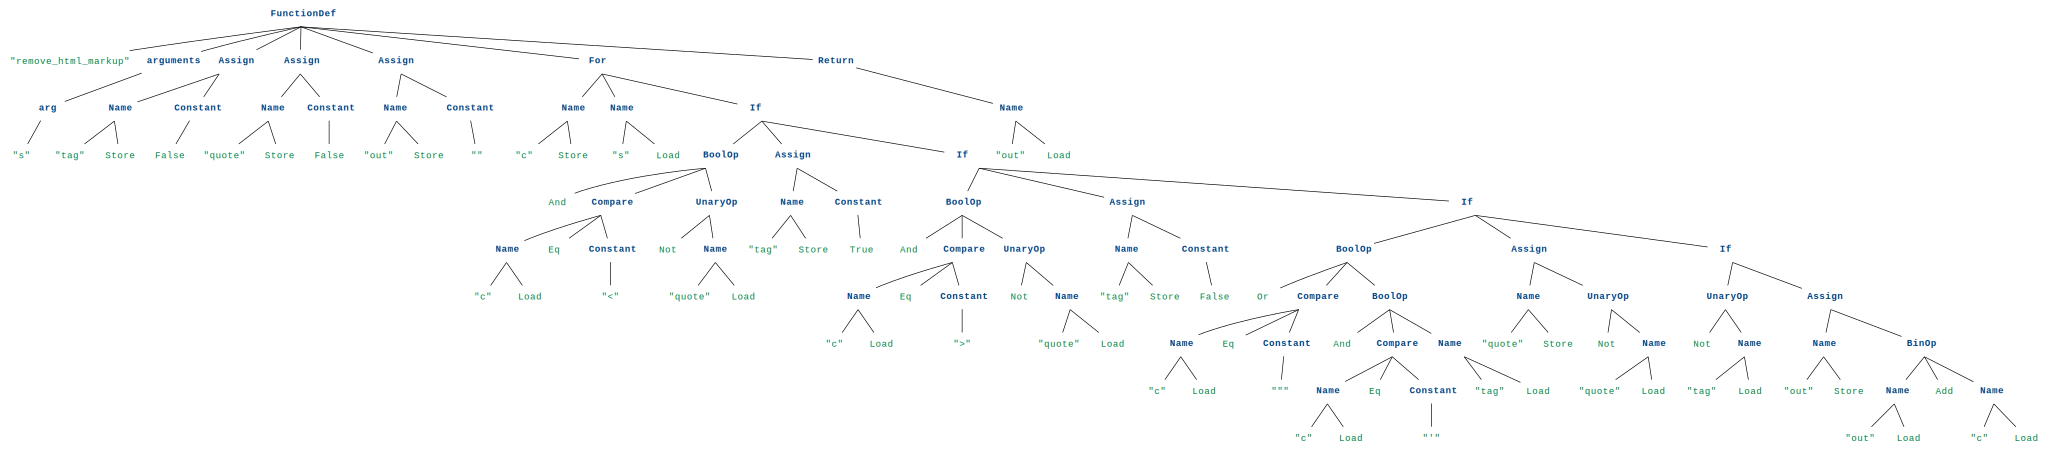

In [238]:
meta_repairer = Repairer(html_debugger, mutator_class=MetaMutator, log=True)
show_ast(remove_html_markup_tree())

In [239]:
good_fitness = meta_repairer.fitness(remove_html_markup_tree(), concurrent_mode = False)
good_fitness

0.99

In [240]:
meta_repairer.repair(iterations = 1000)

Evolving population: iteration  91/1000 fitness = 1.0      
Best code (fitness = 1.0):
def remove_html_markup(s):
    tag = False
    quote = False
    pass
    out = ''
    for c in s:
        if c == '<' and not quote:
            tag = True + True
        elif c == '>' and not quote:
            tag = False
            quote = False
        elif c == "'" and tag or tag and c == '"':
            if c == '"' or c == "'" and tag:
                quote = not quote
        elif not tag:
            out = out + c
    return out

Reduced code (fitness = 1.0):
def remove_html_markup(s):
    tag = False
    quote = False
    out = ''
    for c in s:
        if c == '<' and not quote:
            tag = True + True
        elif c == '>' and not quote:
            tag = False
        elif c == "'" and tag or tag and c == '"':
            quote = not quote
        elif not tag:
            out = out + c
    return out

It took the MetaRepairer 657.472690820694 seconds to repair the given code


(<_ast.Module at 0x7fcd5b419b50>, 1.0)